<h1 style="text-align: center;">
 Statistical Time Series Forecasting : an Ode to the Efficient Markets Hypothesis

<center><img src="https://miro.medium.com/max/1200/1*yhdDeIpwPVDCyrTBpVGJKA.jpeg"/></center>

<h2 style="text-align: center;">
 Stefan Obradovic
</h2>
<h3 style="text-align: center;">
    May 2021, University of Maryland, College Park
</h3>

- - - 

<h1 style="text-align: Center;">
Introduction
</h1>

### It is no secret that predicting movements of financial markets is ***incredibly difficult***.

### According to the strong-form *Efficient Market Hypothesis*, asset prices reflect all available information public and private. This suggests that the price of stocks always reflect all known historical indicators and any movements in the price of a stock are due to newly revealed information and thus inherently unpredictable.

### In his 1973 work, *A Random Walk Down Wall Street*, American Economist Burton Malkiel argued that future movements in the price of a stock cannot be accurately predicted by looking at its price history. Rather, he posed that the price of a stock can best be modeled by a Statistical process called "A Random Walk" whereby the price of a stock deviates from a central value in a random and unpredictable (stochastic) way.

### Since its publication, the Efficient Market Hypothesis has been the target of criticism by many notable investors, asset managers, and economists. Perhaps the most notable of these individuals is investor and CEO of Berkshire Hathaway, Warren Buffett who famously said, "I'd be a bum on the street with a tin cup if the markets were efficient." After all, as noted by Fidelity Investments Mutual Fund manager Peter Lynch, the efficient market hypothesis is at odds with the random walk hypothesis: if asset prices are rational and based on all available information then they are *not random*, if the change in asset prices is random, then asset prices are not in fact rational.

## So, is the Efficient Market Hypothesis true? If not, how do we identify and exploit the inefficiencies?

- - -

## Project Motivation:

### If we can accurately predict future stock prices based on historical trends, we can exploit market inefficiencies by purchasing stocks that are currently underperforming and selling stocks that are currently overperforming.

### Generating forecasts is an important tool for many other valuation methods such as the Discounted Cash Flow Model. Investors often use analyst ratings, price targets, and forecasts as signal inputs to more complicated trading algorithms. 

### Here we build on [previous research](https://www.smithinvestmentfund.com/blog/research-introduction-to-statistical-time-series-forecasting-and-stock-market-clustering) by expanding on advanced statistical time-series approaches and establish the groundwork for a statisticial time-series forecasting package that will be used for alpha discovery.


- - -

## Getting Started

In [10]:
import os
os.chdir('..')
from infrastructure.backtesters import full_backtesters as fb
from infrastructure.alpha_eval import apply_metric_func
from siftools import sif_utils as su, operators as op, metrics
from siftools.abstractalpha import AbstractAlpha
os.chdir('examples')
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 9)
from pmdarima.arima import ADFTest
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [556]:
from fastdtw import fastdtw
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import dtw
import seaborn as sbn
from pmdarima.arima import ndiffs

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [565]:
def extract_data(stocks, start_year, start_month, start_day, end_year, end_month, end_day):
    start_date = datetime.datetime(start_year, start_month, start_day)
    end_date = datetime.datetime(end_year, end_month, end_day)
    
    #fundamental = su.get_fundamental_filled(stocks, start_date, end_date, ['debt', 'assets'])
    equity_data = su.get_equity_data(stocks, start_date, end_date)
    #equity_factors = list(set(config.table_columns['equity']).intersection(factors))
    
    return equity_data

In [607]:
def extract_fund_data(stocks, start_year, start_month, start_day, end_year, end_month, end_day):
    start_date = datetime.datetime(start_year, start_month, start_day)
    end_date = datetime.datetime(end_year, end_month, end_day)
    
    fundamental = su.get_fundamental_filled(stocks, start_date, end_date, ['debt', 'assets', 'fcf'])
    
    return fundamental

In [567]:
top_n = 10
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

In [568]:
tickers = sorted(su.get_universe_tickers(top_n, start_date, end_date))
print(tickers)

['AAPL', 'AMZN', 'BABA', 'BAC', 'BRK.B', 'FB', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'V', 'XOM']


In [613]:
fundamental_data = extract_fund_data(tickers, start_year=2008, start_month=1, start_day=1, end_year=2020, end_month=1, end_day=1)

In [570]:
equity_data = extract_data(tickers, start_year=2018, start_month=1, start_day=1, end_year=2020, end_month=1, end_day=1)
equity_data.keys()

dict_keys(['open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'lastupdated'])

In [18]:
len(equity_data['close']['AAPL'])

503

## Let's take a look at Apple's stock price between 2018 and 2020

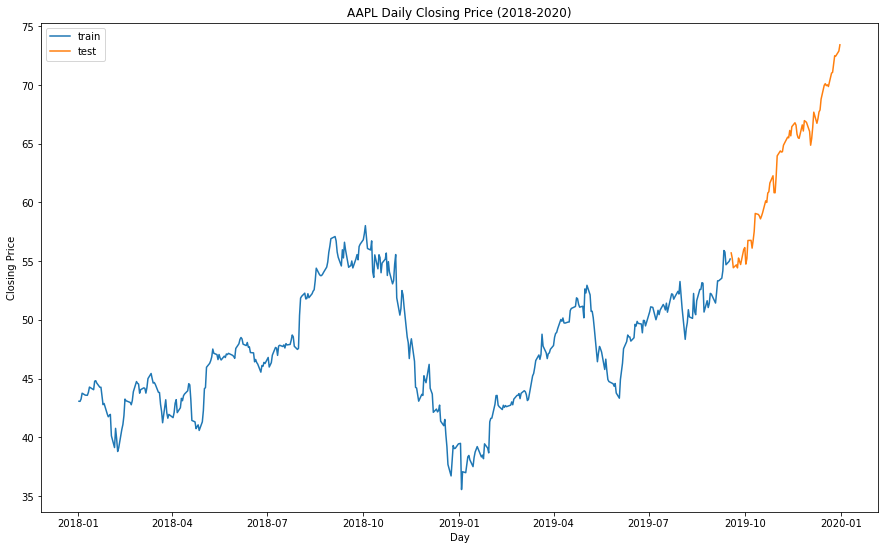

In [705]:
# We use the first 430 days as the training period and the remaining 73 days as the testing period
aapl = equity_data['close']['AAPL']
train = aapl[:430]
test = aapl[430:]

plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('AAPL Daily Closing Price (2018-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [706]:
print(f'Average stock price in period is {np.mean(train)}')
print(f'Standard deviation of stock price in period is {np.std(train)}')

Average stock price in period is 47.373439534883765
Standard deviation of stock price in period is 4.936446657245711


In [707]:
from statsmodels.tsa.stattools import adfuller
X = train.values
result = adfuller(X)
if result[1] > 0.01:
    print('The training set is likely non-stationary')
else:
    print('The training set is likely stationary')
    
X = test.values
result = adfuller(X)
if result[1] > 0.01:
    print('The testing set is likely non-stationary')
else:
    print('The testing set is likely stationary')

The training set is likely non-stationary
The testing set is likely non-stationary


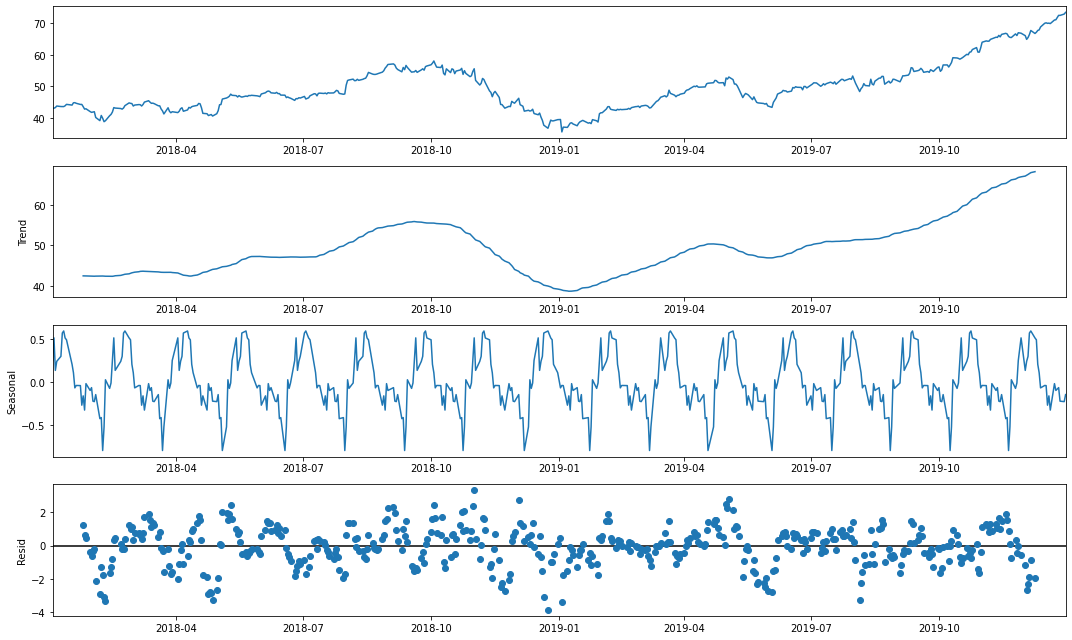

In [708]:
res = seasonal_decompose(pd.DataFrame(aapl), model='additive', period = 30)
res.plot()
plt.show()

### We notice that Apple's stock price exhibits seasonal behavior and has an overall positive trend in the testing period with little to no overall trend in the training period.

## We will also be forecasting Apple's Free Cash Flows as an example

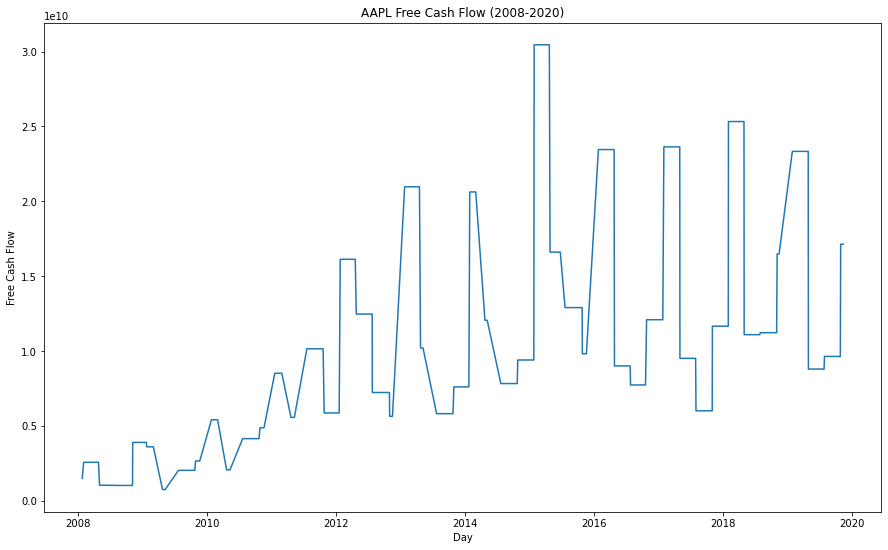

In [709]:
fcf = fundamental_data['fcf']['AAPL']
plt.plot(fcf)
plt.xlabel('Day')
plt.ylabel('Free Cash Flow')
plt.title('AAPL Free Cash Flow (2008-2020)')
plt.show()

In [710]:
train_fcf = fcf[:300]
test_fcf = fcf[300:]

In [711]:
print(f'Average fcf in period is {np.mean(fcf)}')
print(f'Standard deviation of fcf in period is {np.std(fcf)}')

Average fcf in period is 10813538653.366583
Standard deviation of fcf in period is 7374815206.552653


In [712]:
X = fcf.values
result = adfuller(X)
if result[1] > 0.01:
    print('The time-series is likely non-stationary')
else:
    print('The time-series is likely stationary')

The time-series is likely stationary


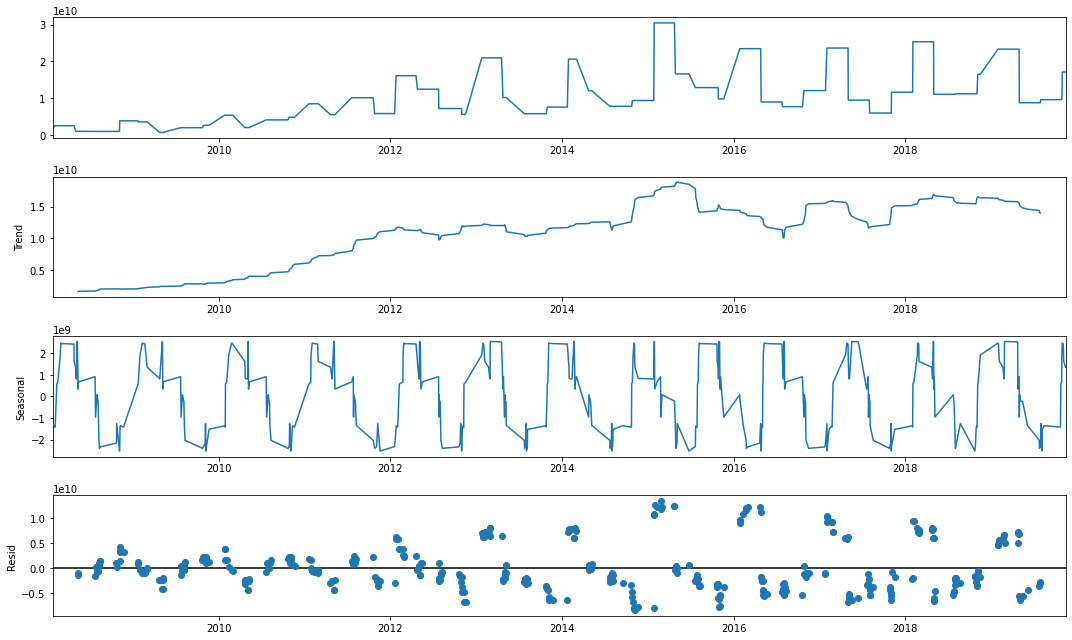

In [713]:
res = seasonal_decompose(pd.DataFrame(fcf), model='additive', period = 30)
res.plot()
plt.show()

### We notice that Apple's Free Cash Flows exhibit yearly seasonality with little to no trend.

### Are Apple's stock prices normally distributed?

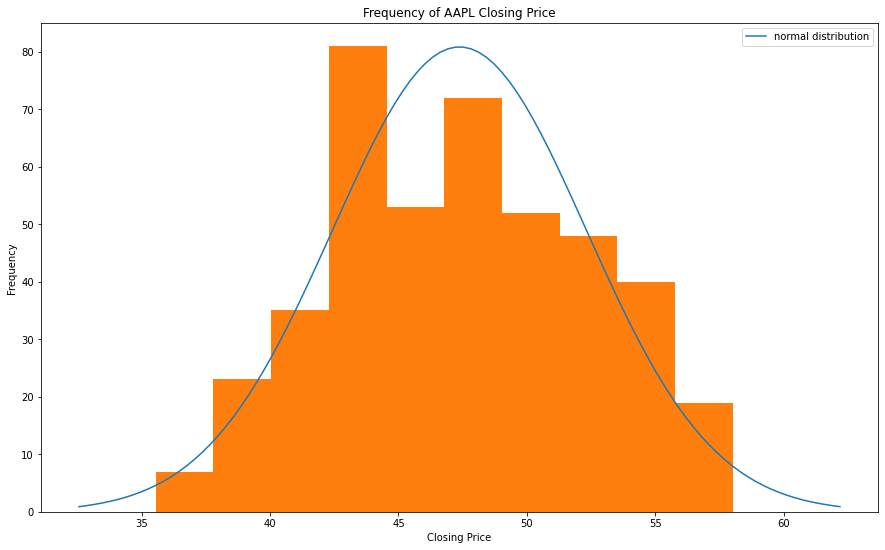

In [714]:
import scipy.stats as stats

mu = np.mean(train)
sigma = np.std(train)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma)*1000, label = 'normal distribution')
plt.hist(train)
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.title('Frequency of AAPL Closing Price')
plt.legend()
plt.show()

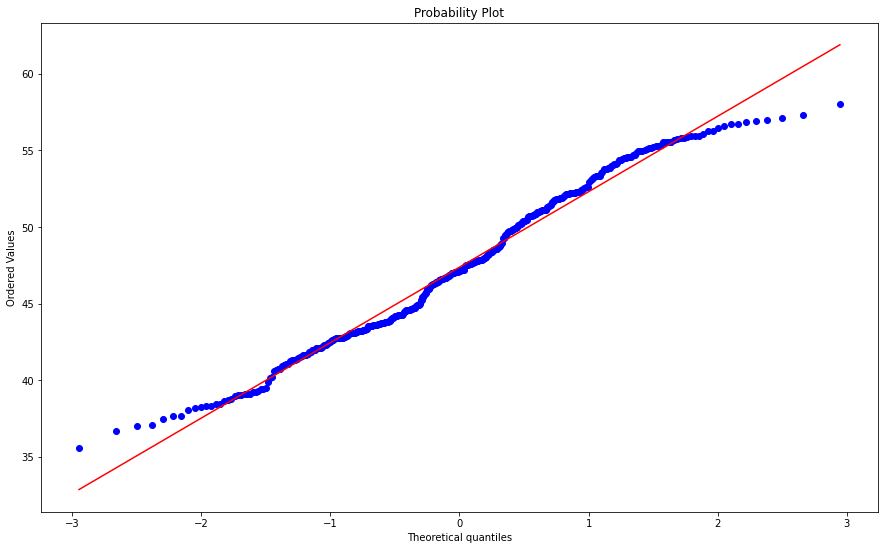

In [715]:
import pylab
stats.probplot(train, dist='norm', plot=pylab)
pylab.show()

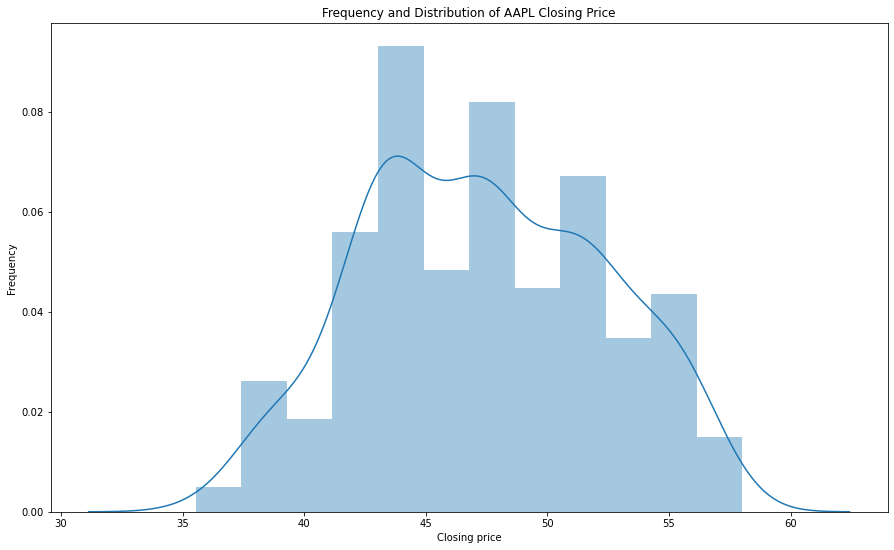

In [716]:
import seaborn as sns
sns.distplot(train)
plt.xlabel('Closing price')
plt.ylabel('Frequency')
plt.title('Frequency and Distribution of AAPL Closing Price')
plt.show()

In [717]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import chisquare
from statsmodels.stats.diagnostic import lilliefors

print('Statistical Tests of Normality for AAPL Close Price:')
stat, p = shapiro(train)
if p > 0.01:
    print(f'probably Gaussian: p = {p}')
else:
    print(f'probably not Gaussian: p = {p}')
    
stat, p = normaltest(train)
if p > 0.01:
    print(f'probably Gaussian: p = {p}')
else:
    print(f'probably not Gaussian: p = {p}')
    
stat, p = chisquare(train)
if p > 0.01:
    print(f'probably Gaussian: p = {p}')
else:
    print(f'probably not Gaussian: p = {p}')
    
stat, p = lilliefors(train)
if p > 0.01:
    print(f'probably Gaussian: p = {p}')
else:
    print(f'probably not Gaussian: p = {p}')

Statistical Tests of Normality for AAPL Close Price:
probably not Gaussian: p = 2.827665775839705e-05
probably not Gaussian: p = 2.307808129464808e-08
probably Gaussian: p = 1.0
probably not Gaussian: p = 6.270939802395728e-05


### Although graphically it may seem as though Apple's stock prices are normally distributed in the training period, statistical tests of normality state that they are not.

## Are stock returns (daily percent change) normally distributed?

Number of observations in training period (outliers removed): 416


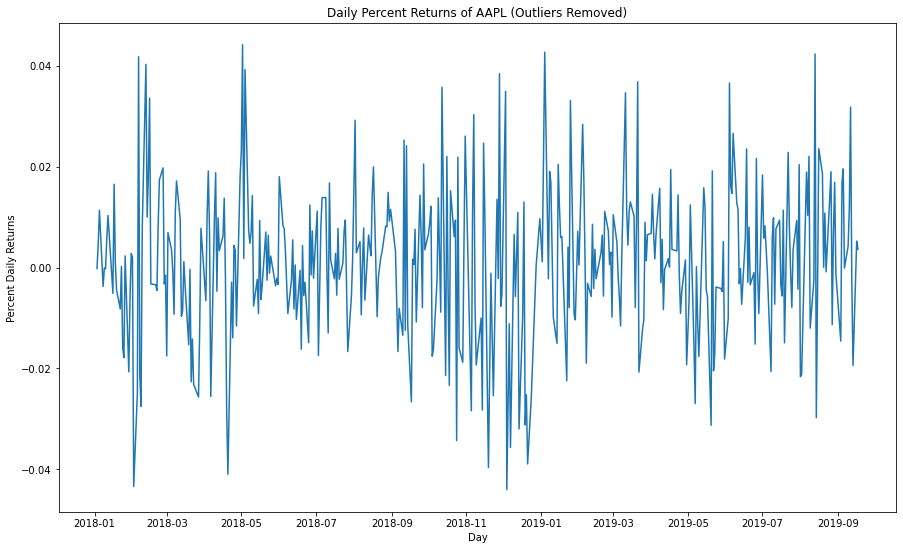

In [718]:
rets = train.pct_change()[1:]

cut_off = np.std(rets) * 2.5
lower, upper = np.mean(rets) - cut_off, np.mean(rets) + cut_off
outliers_removed = rets[~((rets-rets.mean()).abs() > 2.5*rets.std())]
print(f'Number of observations in training period (outliers removed): {len(outliers_removed)}')
plt.plot(outliers_removed)
plt.ylabel('Percent Daily Returns')
plt.xlabel('Day')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.show()

In [719]:
print(f'Average returns in period is {np.mean(outliers_removed)}')
print(f'Standard deviation of returns in period is {np.std(outliers_removed)}')

Average returns in period is 0.001181691547771148
Standard deviation of returns in period is 0.014976652504982807


In [720]:
X = outliers_removed.values
result = adfuller(X)
if result[1] > 0.01:
    print('The time-series is likely non-stationary')
else:
    print('The time-series is likely stationary')

The time-series is likely stationary


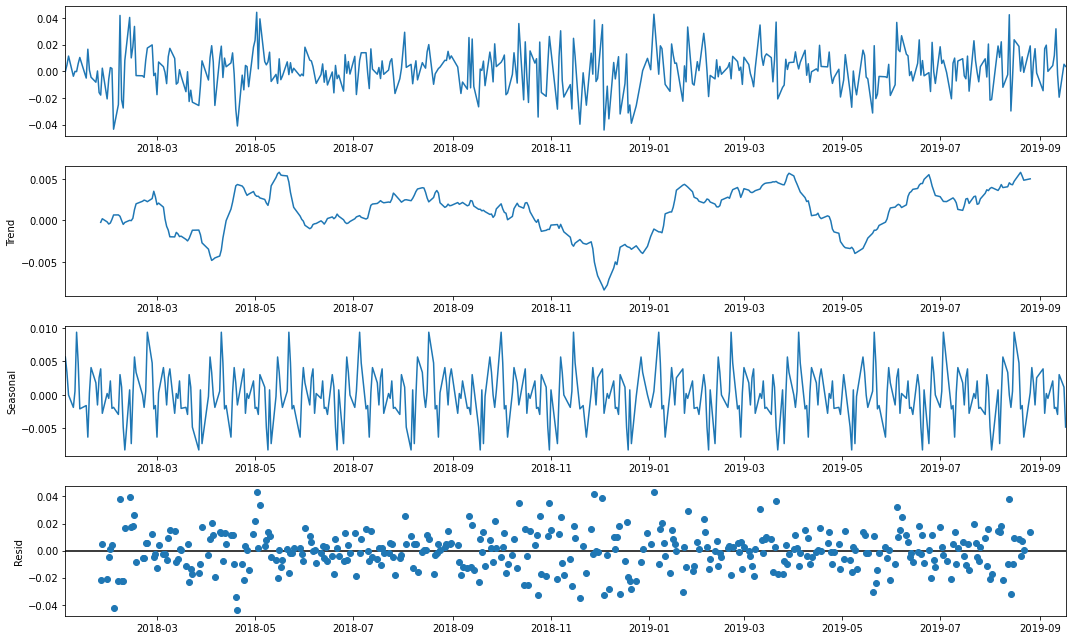

In [721]:
res = seasonal_decompose(pd.DataFrame(outliers_removed), model='additive', period = 30)
res.plot()
plt.show()

### We notice that daily returns exhibit bi-monthly seasonality and no trend

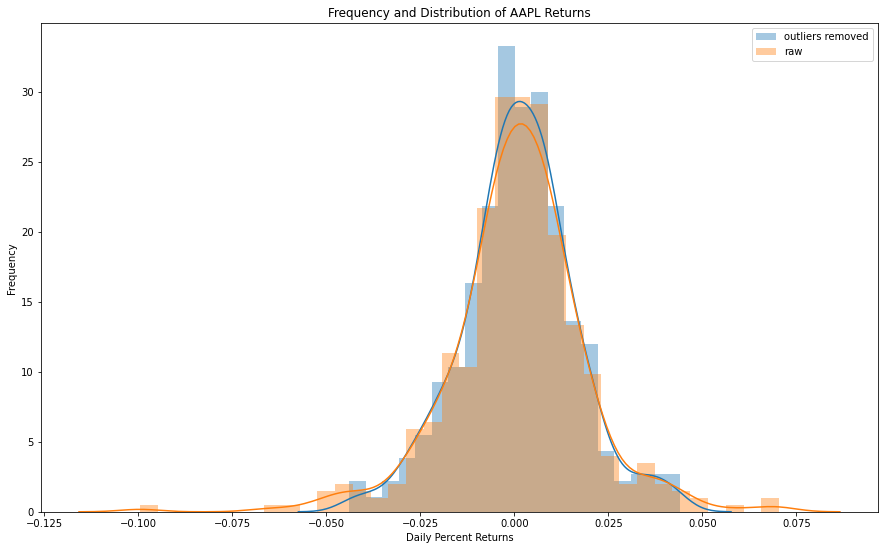

In [722]:
sns.distplot(outliers_removed, label='outliers removed')
sns.distplot(rets, label='raw')
plt.legend()
plt.xlabel('Daily Percent Returns')
plt.ylabel('Frequency')
plt.title('Frequency and Distribution of AAPL Returns')
plt.show()

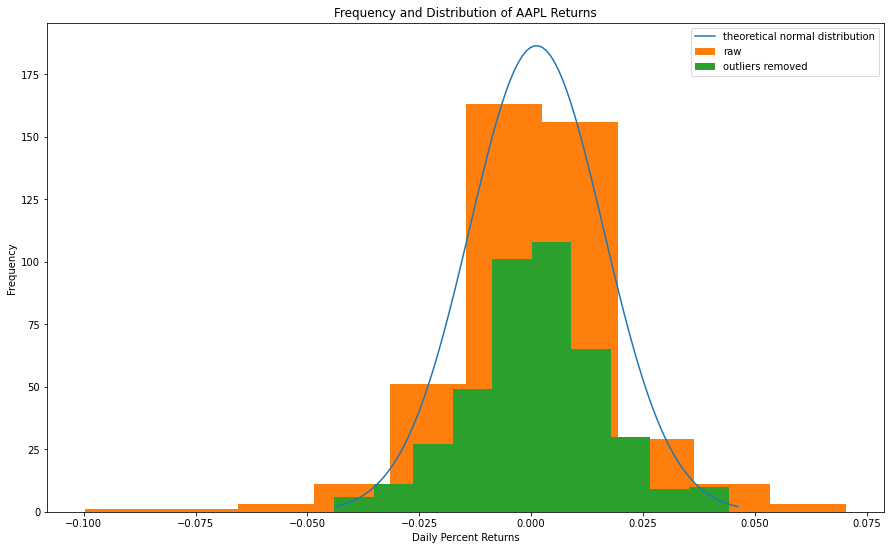

In [723]:
mu = np.mean(outliers_removed)
sigma = np.std(outliers_removed)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma)*7, label = 'theoretical normal distribution')
plt.hist(rets, label='raw')
plt.hist(outliers_removed, label='outliers removed')
plt.legend()
plt.xlabel('Daily Percent Returns')
plt.ylabel('Frequency')
plt.title('Frequency and Distribution of AAPL Returns')
plt.show()

In [724]:
print('Statistical Tests of Normality for Raw Returns:')
stat, p = shapiro(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
stat, p = normaltest(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
stat, p = chisquare(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
stat, p = lilliefors(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
print('')
print('Statistical Tests of Normality for Returns (Outliers Removed):')
stat, p = shapiro(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
stat, p = normaltest(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
stat, p = chisquare(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')
    
stat, p = lilliefors(outliers_removed)
if p > 0.01:
    print(f'probably Gaussian: {p}')
else:
    print(f'probably not Gaussian: {p}')

Statistical Tests of Normality for Raw Returns:
probably not Gaussian: 0.0035497962962836027
probably Gaussian: 0.07845852031019541
probably Gaussian: 1.0
probably Gaussian: 0.0249787690041888

Statistical Tests of Normality for Returns (Outliers Removed):
probably not Gaussian: 0.0035497962962836027
probably Gaussian: 0.07845852031019541
probably Gaussian: 1.0
probably Gaussian: 0.0249787690041888


### The fat tails in the raw returns distribution indicate that extreme events occur more frequently in reality than what a normal distribution would predict. However, when removing outliers (2.5 standard deviations away), it seems as though daily returns are roughly normally distributed, so we can use the normal assumption when forecasting these returns.

In [725]:
start = (test[0]-train[-1])/train[-1]
test_new = test.pct_change()
test_new[0] = start
train = outliers_removed
test = test_new

### Under the Efficient Market Hypothesis, the price at any given moment already reflects all known public and private information and thus we are unable to predict the future stock price. We can thus naively predict that the stock price tomorrow will be the stock price today under the assumption that market prices are rational and not random.

### Naive Method:
#### $ \hat{y}_{T+h|T} = y_{T}. $
#### Assumption: daily returns tomorrow is going to equal the daily returns today

In [726]:
def naive(df):
    return df[-1]

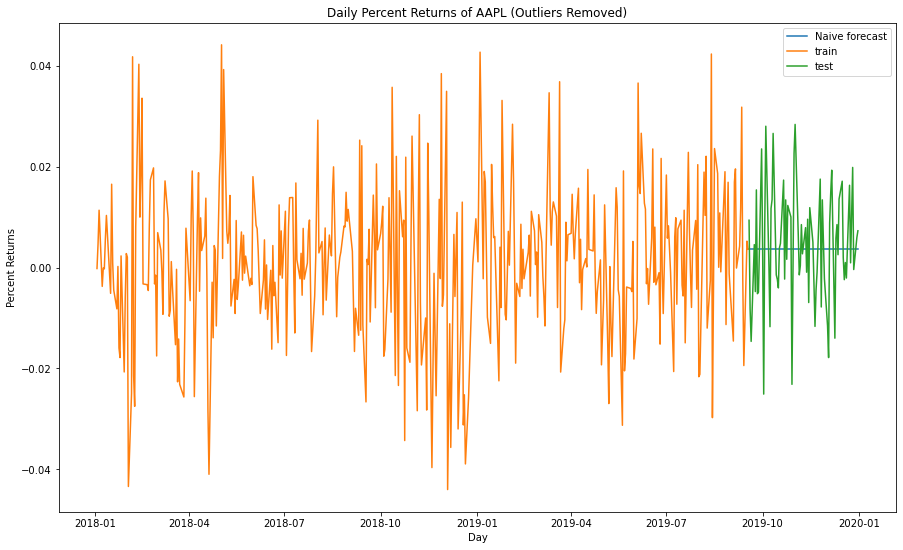

In [823]:
forecast = []
for day in test:
    forecast.append(naive(train))
forecast_naive = pd.Series(forecast, index = test.index)

plt.plot(forecast_naive, label="Naive forecast")
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()

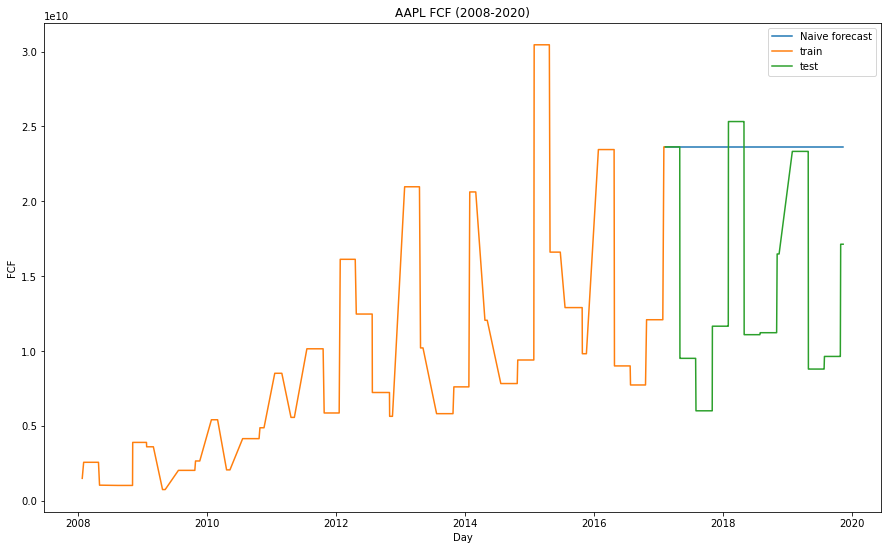

In [728]:
forecast = []
for day in test_fcf:
    forecast.append(naive(train_fcf))
forecast_naive = pd.Series(forecast, index = test_fcf.index)

plt.plot(forecast_naive, label="Naive forecast")
plt.plot(train_fcf, label='train')
plt.plot(test_fcf, label='test')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()

### We see here that we are missing a fundamental aspect of the efficient market hypothesis. Although the hypothesis claims that asset prices reflect all known public and private information, information itself is not held constant. Rather, new information is constantly being made available, but is it random?

#### Thus, lets ease our assumption that information is held constant and that instead, information is made available at the close of each day (in reality, information is constantly made available and this can be seen from changes in intra-day price, but for simplification we consider it a "once-a-day" event). Now, we naively predict the daily return tomorrow as the daily return today and then adjust our information at the end of the day to create a new rolling forecast. 

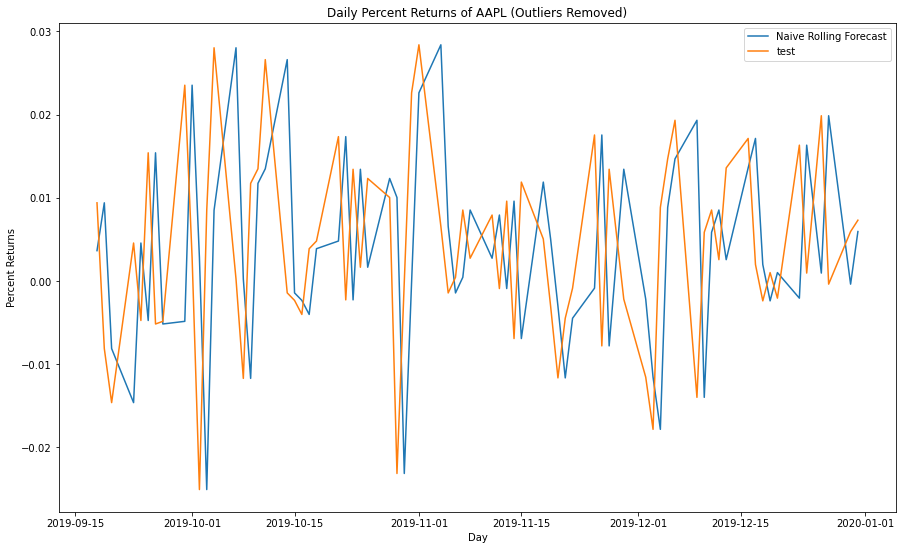

In [824]:
rolling = train.tolist()
forecast = []
for day in test:
    forecast.append(naive(rolling))
    rolling.append(day)
roll_forecast_naive = pd.Series(forecast, index = test.index)

plt.plot(roll_forecast_naive, label="Naive Rolling Forecast")
#plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()

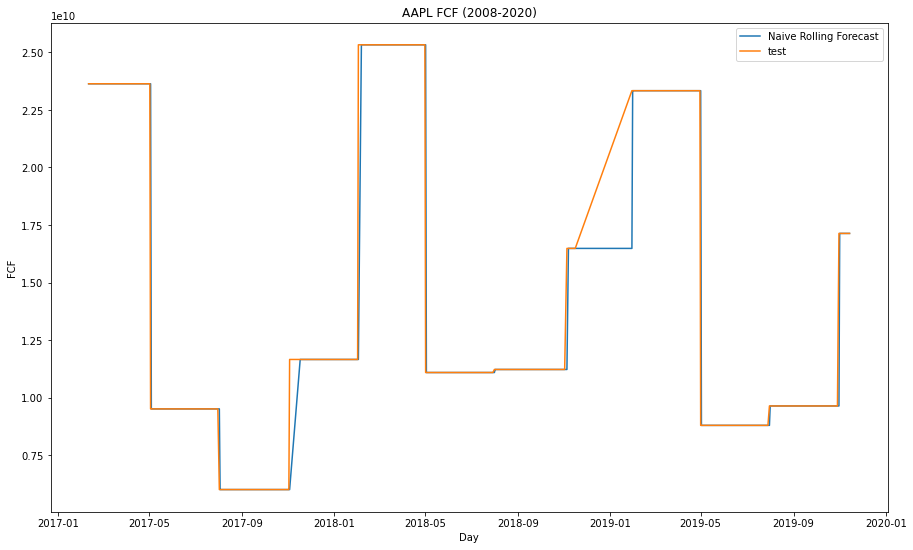

In [730]:
rolling = train_fcf.tolist()
forecast = []
for day in test_fcf:
    forecast.append(naive(rolling))
    rolling.append(day)
roll_forecast_naive = pd.Series(forecast, index = test_fcf.index)

plt.plot(roll_forecast_naive, label="Naive Rolling Forecast")
plt.plot(test_fcf, label='test')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()

#### On face value, this seems like a fairly good daily prediction, but how do we measure time-series forecast prediction accuracy? Using the naive method as a baseline model, are there models that are able to predict better?

## Measuring Accuracy:

#### There are many different metrics to evaluate prediction performance:
1) Mean Absolute Error (MAE)
2) Root Mean Squared Error (RMSE)
3) Mean Absolute Percentage Error (MAPE)
4) Symmetric Mean Absolute Percentage Error (sMAPE)
5) Mean Absolute Scaled Error (MASE)

## RMSE vs MAE
### $Error = e_{t} = y_{t} - \hat{y}_{t}$ measures difference between predicted and actual
### $MAE = mean(|e_{t}|)$ measures mean absolute error
### $RMSE = \sqrt(mean(e_{t}^2))$ measures the square root of mean squared error
#### Both MAE and RMSE are scale-dependent measures. This means that you cannot compare MAE/RMSE between time series using different units or scaled to different magnitudes.
#### Forecasting methods that minimize MAE produce a median forecast, methods that minimize RMSE produce a mean forecast.

In [731]:
def rmse(predictions, targets):
    return np.sqrt(sum((targets - predictions) ** 2)/len(targets))

In [732]:
def mae(predictions, targets):
    return np.mean(abs(targets - predictions))

## Percentage Errors
### $p_{t} = 100*e_{t}/y_{t}$ measures percent error
### $MAPE = mean(|p_{t}|)$ measures mean absolute percent error
### $sMAPE = mean(200*|e_{t}|/(y_{t}+\hat{y}_{t}))$ a "symmetric" MAPE
#### MAPE is undefined if $y_{t} = 0$ and place larger penalty on negative errors than positive ones
#### sMAPE is still unstable for $y_{t}$ values close to 0 and can be negative

#### Recommended: DO NOT USE PERCENTAGE ERROR METRICS

In [733]:
def mape(predictions, targets):
    return np.mean(abs(100*(targets - predictions)/targets))

In [734]:
def smape(predictions, targets):
    return np.mean(200*abs(targets-predictions)/(targets+predictions))

## MASE (Scaled Error)

In [735]:
def mase(predictions, targets, compare_pred):
    return mae(predictions, targets)/mae(compare_pred, targets)

In [736]:
def calculate_aic(n, mse, num_params):
    aic = n * log(mse) + 2 * num_params
    return aic

In [737]:
def calculate_aicc(n, mse, num_params):
    aicc = calculate_aic(n, mse, num_params) + (2*num_params*num_params + 2*num_params)/(n-num_params-1)
    return aicc

In [738]:
def calculate_bic(n, mse, num_params):
    aic = n * log(mse) + num_params * np.log(n)
    return aic

#### Now, let's revisit the performance of the naive model

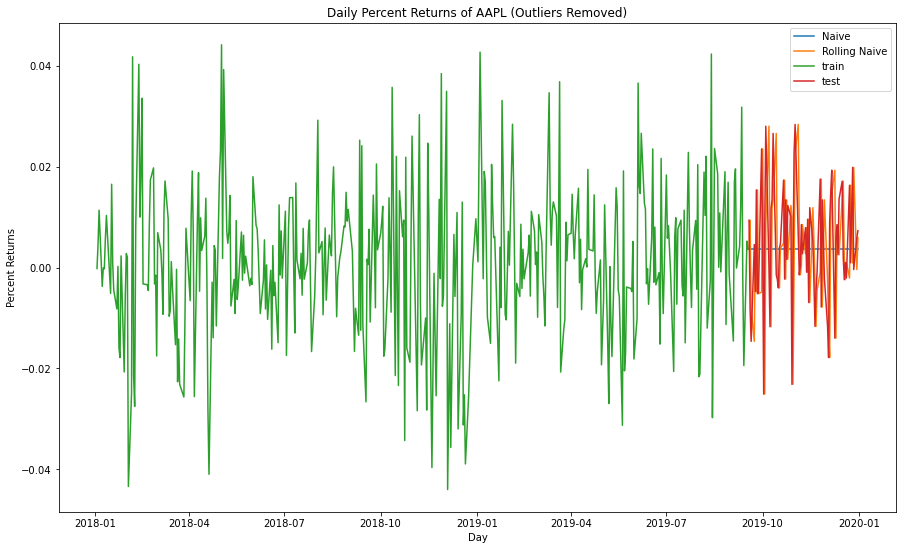

Naive Forecast Performance:
RMSE: 0.011287842708437974
MAE: 0.008991016345825545
MAPE: 208.87499843822985

Rolling Naive Forecast Performance:
RMSE: 0.01593883562529539
MAE: 0.013154739813797734
MAPE: 758.789009538245


In [825]:
forecast = []
for day in test:
    forecast.append(naive(train))
forecast_naive = pd.Series(forecast, index = test.index)

rolling = train.tolist()
forecast2 = []
for day in test:
    forecast2.append(naive(rolling))
    rolling.append(day)
roll_forecast_naive = pd.Series(forecast2, index = test.index)

plt.plot(forecast_naive, label="Naive")
plt.plot(roll_forecast_naive, label="Rolling Naive")
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()
print('Naive Forecast Performance:')
print(f'RMSE: {rmse(forecast_naive, test)}')
print(f'MAE: {mae(forecast_naive, test)}')
print(f'MAPE: {mape(forecast_naive, test)}')
print('')
print('Rolling Naive Forecast Performance:')
print(f'RMSE: {rmse(roll_forecast_naive, test)}')
print(f'MAE: {mae(roll_forecast_naive, test)}')
print(f'MAPE: {mape(roll_forecast_naive, test)}')

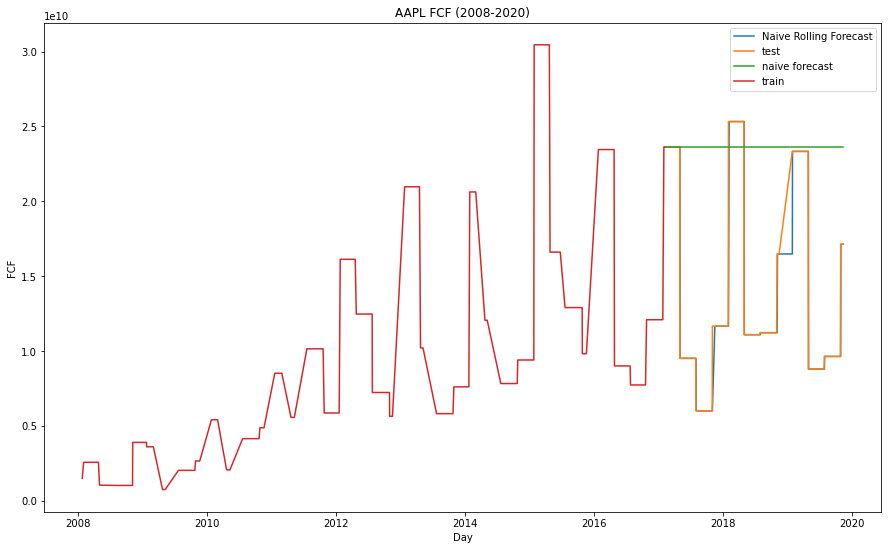

Naive Forecast Performance:
RMSE: 11121271664.946615
MAE: 9140673267.326733
MAPE: 98.21867996622576

Rolling Naive Forecast Performance:
RMSE: 3109623667.97586
MAE: 854742574.2574258
MAPE: 7.111545222397059


In [740]:
forecast = []
for day in test_fcf:
    forecast.append(naive(train_fcf))
forecast_naive = pd.Series(forecast, index = test_fcf.index)

rolling = train_fcf.tolist()
forecast2 = []
for day in test_fcf:
    forecast2.append(naive(rolling))
    rolling.append(day)
roll_forecast_naive = pd.Series(forecast2, index = test_fcf.index)

plt.plot(roll_forecast_naive, label="Naive Rolling Forecast")
plt.plot(test_fcf, label='test')
plt.plot(forecast_naive, label='naive forecast')
plt.plot(train_fcf, label='train')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()
print('Naive Forecast Performance:')
print(f'RMSE: {rmse(forecast_naive, test_fcf)}')
print(f'MAE: {mae(forecast_naive, test_fcf)}')
print(f'MAPE: {mape(forecast_naive, test_fcf)}')
print('')
print('Rolling Naive Forecast Performance:')
print(f'RMSE: {rmse(roll_forecast_naive, test_fcf)}')
print(f'MAE: {mae(roll_forecast_naive, test_fcf)}')
print(f'MAPE: {mape(roll_forecast_naive, test_fcf)}')

----------

## Now, lets take a tour of [Statistical Time-Series Forecasting methods](https://otexts.com/fpp2/) and identify their assumptions, strengths, weaknesses, and evaluate their performance on AAPL.

## The Average Method:
### $\hat{y}_{T+h|T} = \bar{y} = (y_{1}+\dots+y_{T})/T$ where $T$ is the number of observations

### Assumption: The price tomorrow will most likely be the average price of the stock in a historical window
### Hyperparameter: Window Size

In [741]:
def avg(df, window):
    return sum(df[-window:])/len(df[-window:])

### 7-Day Prediction

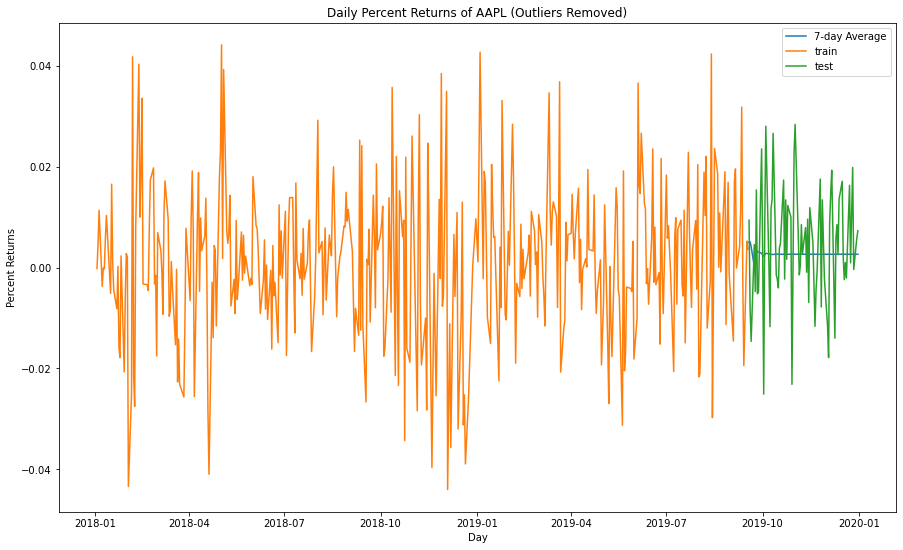

RMSE: 0.011386363207955842
MAE: 0.009010742187678965
MAPE: 173.8968556418701
MASE: 1.0021939501714485


In [826]:
rolling = train.tolist()
forecast = []
for day in test:
    pred = avg(rolling, 7)
    forecast.append(pred)
    rolling.append(pred)
    
forecast = pd.Series(forecast, index = test.index)

plt.plot(forecast, label="7-day Average")
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

### Rolling Day Prediction

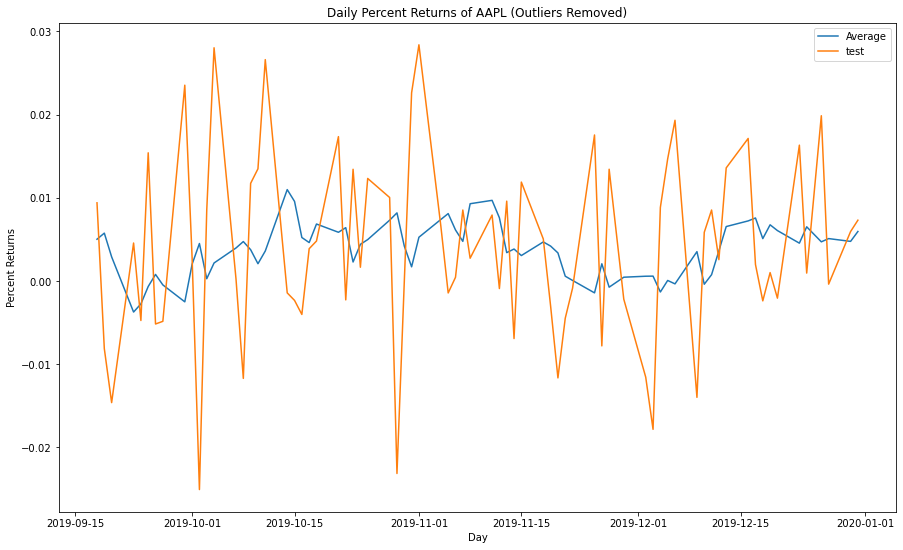

RMSE: 0.012153504727055037
MAE: 0.009785346789308733
MAPE: 262.1685929044076
MASE: 0.7438647155183629


In [827]:
rolling = train.tolist()
forecast = []
for day in test:
    pred = avg(rolling, 7)
    forecast.append(pred)
    rolling.append(day)   
forecast = pd.Series(forecast, index = test.index)

plt.plot(forecast, label="Average")
#plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, roll_forecast_naive)}')

### The N-day prediction using the average method is marginally worse than the performance obtained with the naive N-day prediction. The rolling prediction using the average method is marginally better than the performance obtained with the rolling naive prediction.

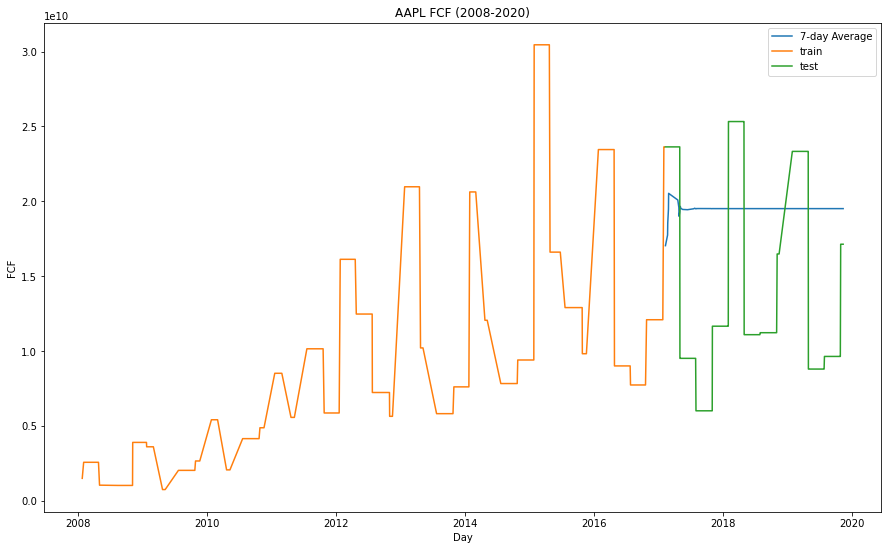

RMSE: 8313866564.114712
MAE: 7684542901.478965
MAPE: 74.98037476834863


In [829]:
rolling = train_fcf.tolist()
forecast = []
for day in test_fcf:
    pred = avg(rolling, 7)
    forecast.append(pred)
    rolling.append(pred)
    
forecast = pd.Series(forecast, index = test_fcf.index)

plt.plot(forecast, label="7-day Average")
plt.plot(train_fcf, label='train')
plt.plot(test_fcf, label='test')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

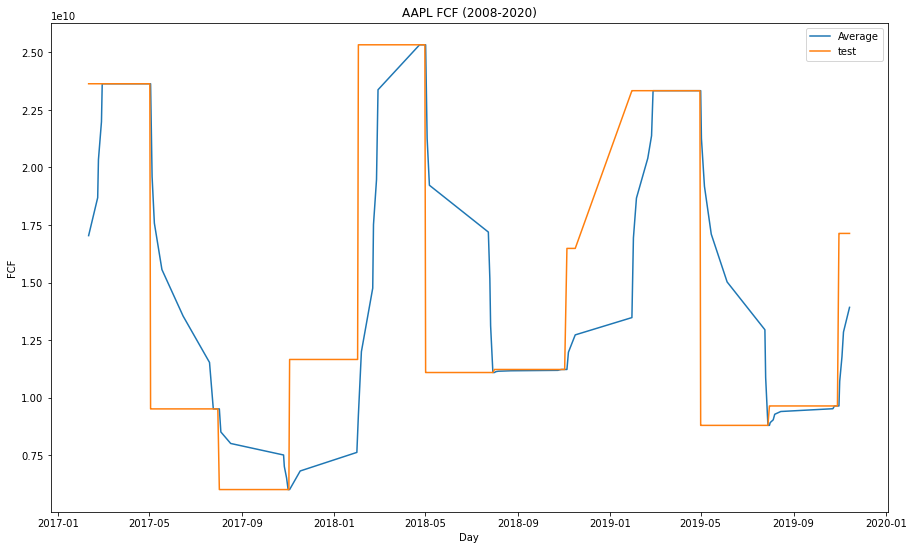

RMSE: 5517305037.382871
MAE: 3550496463.932108
MAPE: 28.59678962280114


In [830]:
rolling = train_fcf.tolist()
forecast = []
for day in test_fcf:
    pred = avg(rolling, 7)
    forecast.append(pred)
    rolling.append(day)   
forecast = pd.Series(forecast, index = test_fcf.index)

plt.plot(forecast, label="Average")
#plt.plot(train, label='train')
plt.plot(test_fcf, label='test')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

## Seasonal Naive Method
## $\hat{y}_{T+h|T} = y_{T+h-m(k+1)}$
### Assumption: The price tomorrow is going to be the price that it was during the last seasonal period
### Hyperparameters: Length of Seasonal Period

In [746]:
def snaive(df, seasonal_period):
    return df[-seasonal_period]

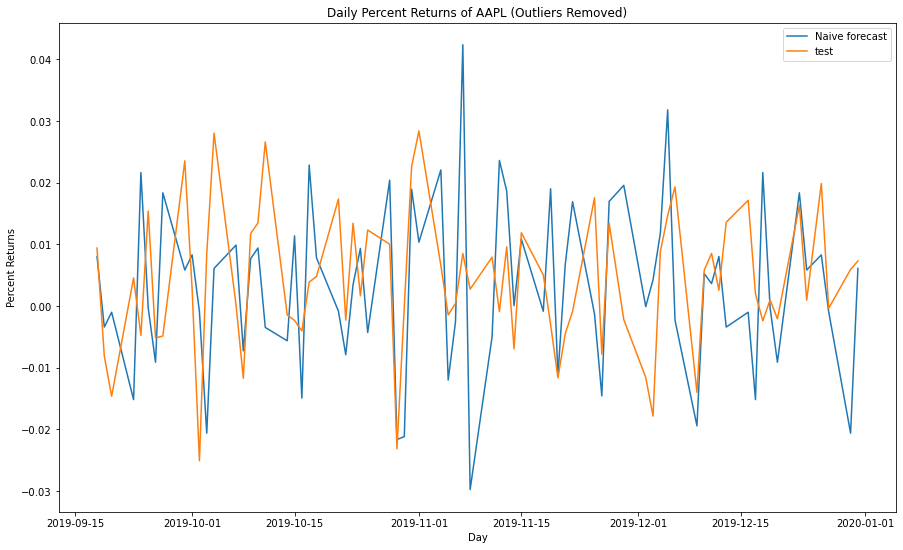

RMSE: 0.01524586325313839
MAE: 0.012381065700956154
MAPE: 594.9698387921085


In [831]:
rolling = train.tolist()
forecast = []
for day in test:
    pred = snaive(rolling, 60)
    forecast.append(pred)
    rolling.append(pred)
forecast = pd.Series(forecast, index = test.index)

plt.plot(forecast, label="Naive forecast")
#plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')

## Drift Method

### Assumption: The price tomorrow will be the price today adjusted by the historical average daily change in price

## $\hat{y}_{T+h|T} = y_{T} + \frac{h}{T-1}\sum_{t=2}^T (y_{t}-y_{t-1}) = y_{T} + h \left( \frac{y_{T} -y_{1}}{T-1}\right).$

### N-day Prediction

In [780]:
def drift(train, horizon):
    y_t = train[-1]
    m = (y_t - train[0]) / len(train)
    h = np.linspace(1,horizon-1, horizon)
    pred = y_t + m * h
    return pred

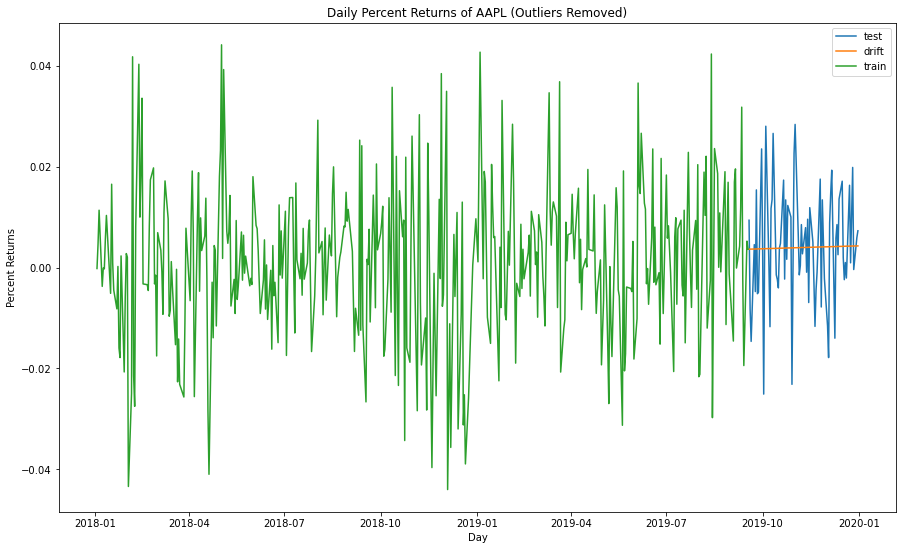

RMSE: 0.011274054540773477
MAE: 0.008992135589176314
MAPE: 221.2601543988286
MASE: 1.0001244846308492


In [832]:
forecast = pd.Series(drift(train, len(test)), index = test.index)

plt.plot(test, label='test')
plt.plot(forecast, label='drift')
plt.plot(train, label='train')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()

print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

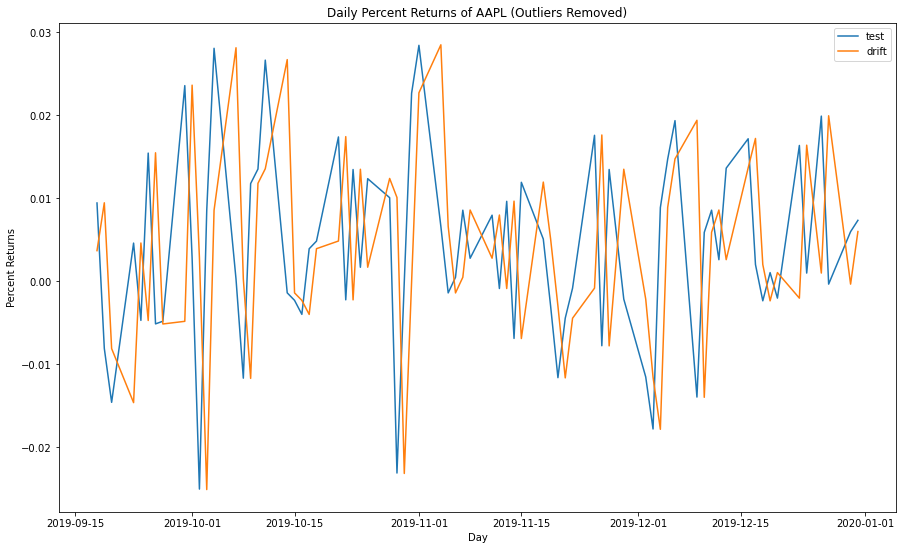

RMSE: [0.01595665]
MAE: [0.013166]
MAPE: [760.34851304]
MASE: [1.46435112]


In [833]:
rolling = train.to_list()
forecast = []
for day in test:
    pred = drift(rolling, 1)
    forecast.append(pred)
    rolling.append(day)
    
forecast = pd.Series(forecast, index = test.index)

plt.plot(test, label='test')
plt.plot(forecast, label='drift')
#plt.plot(train, label='train')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()

print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

### Performance on returns is roughly the same because the data does not have a strong trend

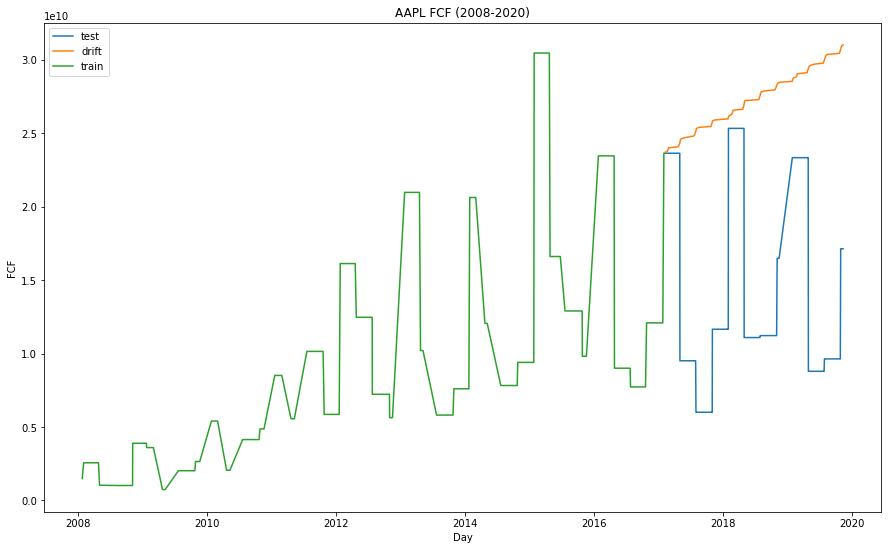

RMSE: 14482378780.303894
MAE: 12466117904.290426
MAPE: 127.18033894368877


In [786]:
forecast = pd.Series(drift(train_fcf, len(test_fcf)), index = test_fcf.index)

plt.plot(test_fcf, label='test')
plt.plot(forecast, label='drift')
plt.plot(train_fcf, label='train')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()

print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

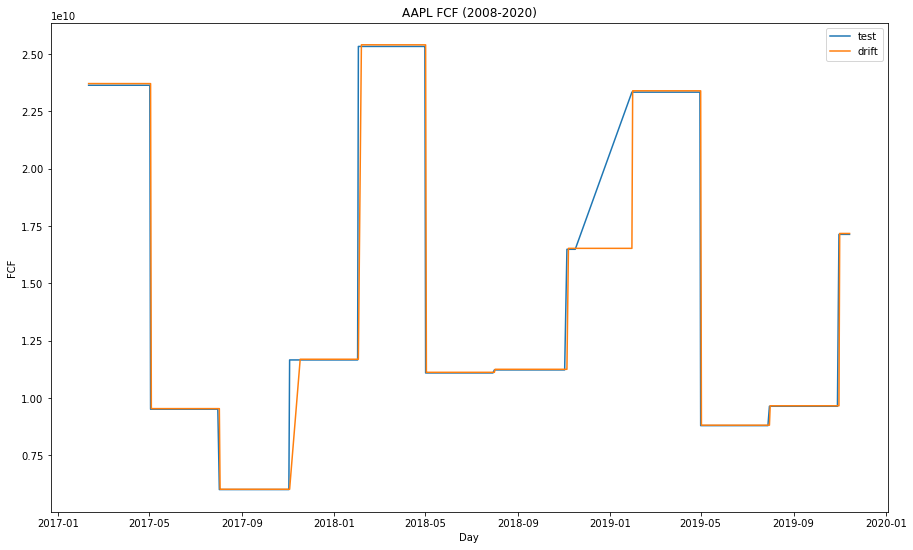

RMSE: [3.11577292e+09]
MAE: [8.9014967e+08]
MAPE: [7.34953188]


In [834]:
rolling = train_fcf.to_list()
forecast = []
for day in test_fcf:
    pred = drift(rolling, 1)
    forecast.append(pred)
    rolling.append(day)
    
forecast = pd.Series(forecast, index = test_fcf.index)

plt.plot(test_fcf, label='test')
plt.plot(forecast, label='drift')
#plt.plot(train, label='train')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()

print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

## Linear Regression
### With a linear model we attempt to fit a line in the form y = mx+b to the time series by minimizing the least squares distance between the line and the actual values

In [820]:
### Assumption: Linear 
from sklearn.linear_model import LinearRegression

def fit_linear(train, test):
    col = train.name
    X = train.reset_index()[col]
    y = test.reset_index()[col]
    
    reg = LinearRegression().fit(X.index.to_numpy().reshape(-1, 1), X.to_numpy().reshape(-1, 1))
    forecast = reg.predict(np.asarray([x+len(X) for x in y.index]).reshape(-1, 1))
    
    forecast = pd.Series(forecast.flatten(), index = test.index)
    
    best_fit = np.arange(0, len(test)+len(train)+1, 1)*reg.coef_+reg.intercept_
    best_fit_index = train.index.append(test.index)
    
    fit_line = pd.Series(best_fit[0][:-1], index = best_fit_index)

    
    return forecast, fit_line

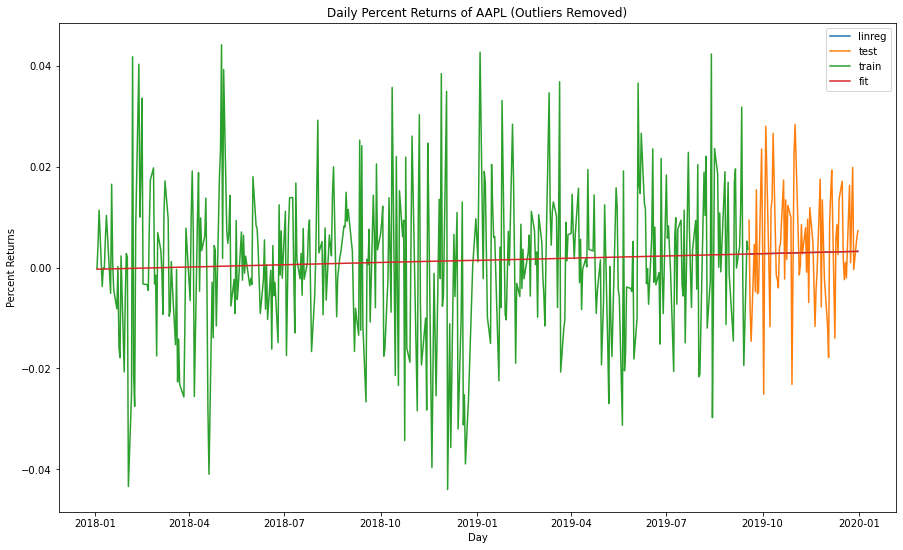

RMSE: 0.01132280740818054
MAE: 0.00897968561141927
MAPE: 183.68436903159784
MASE: 0.9987397715708153


In [835]:
forecast, fit_line = fit_linear(train, test)

plt.plot(forecast, label="linreg")
plt.plot(test, label='test')
plt.plot(train, label='train')
plt.plot(fit_line, label='fit')
plt.title('Daily Percent Returns of AAPL (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

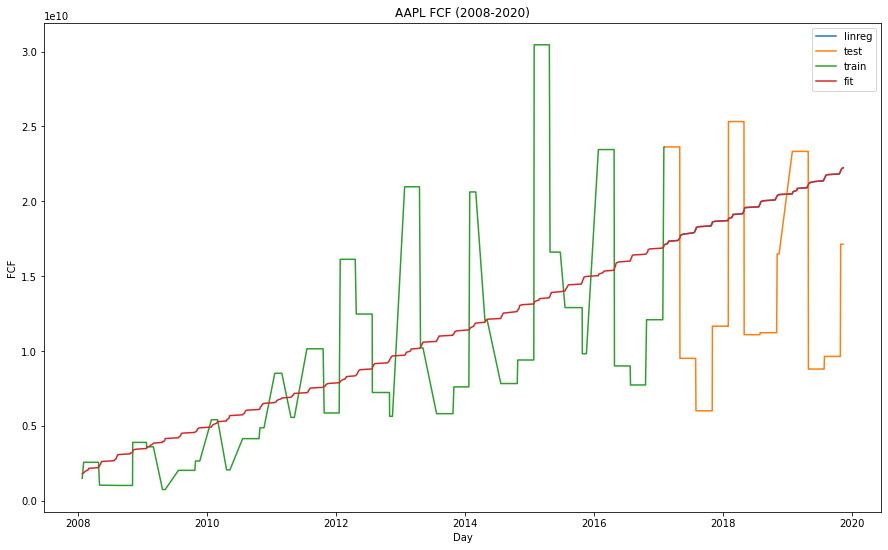

RMSE: 8612570278.594847
MAE: 7996958633.863076
MAPE: 76.6263749653576


In [837]:
forecast, fit_line = fit_linear(train_fcf, test_fcf)

plt.plot(forecast, label="linreg")
plt.plot(test_fcf, label='test')
plt.plot(train_fcf, label='train')
plt.plot(fit_line, label='fit')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

## Polynomial Regression
### With a polynomial regression we attempt to fit an n-degree polynomial to the time series by minimizing the least squares distance between the line and the actual values
### Hyperparameters: polynomial degree

In [927]:
def poly_fit(train, test, order):
    name = train.name
    X = train.reset_index()[name]
    y = test.reset_index()[name]
    
    model = np.polyfit(X.index, X, order)
    predict = np.poly1d(model)
    x_lin_reg = range(0, len(X))
    x_lin_reg2 = range(len(X), len(X)+len(y))
    insample = predict(x_lin_reg)
    outsample = predict(x_lin_reg2)
    
    
    return insample, outsample

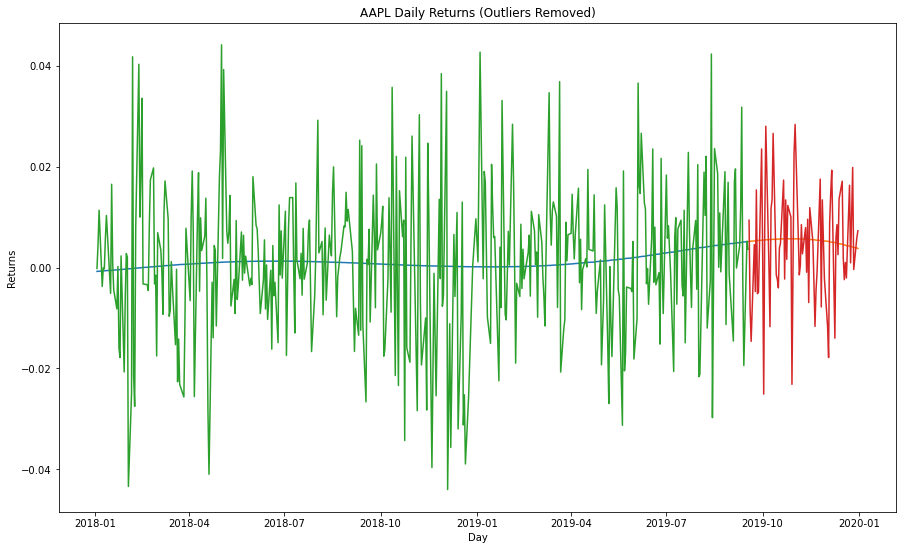

RMSE: 0.011384904671501085
MAE: 0.00912705369374623
MAPE: 273.3993569038351


In [928]:
insample, outsample = poly_fit(train, test, 5)
plt.plot(train.index, insample)
plt.plot(test.index, outsample)
plt.title('AAPL Daily Returns (Outliers Removed)')
plt.xlabel('Day')
plt.ylabel('Returns')
plt.plot(train)
plt.plot(test)
plt.show()

print(f'RMSE: {rmse(outsample, test)}')
print(f'MAE: {mae(outsample, test)}')
print(f'MAPE: {mape(outsample, test)}')

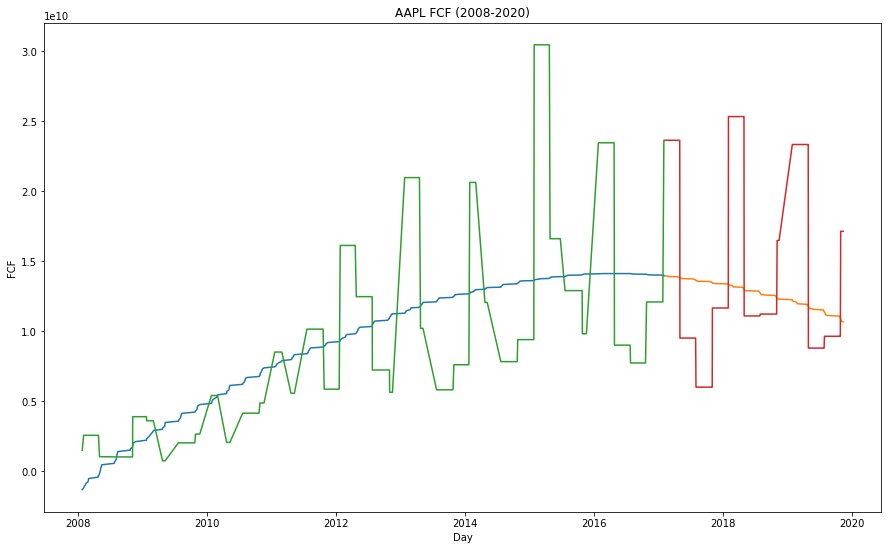

RMSE: 7220935149.711714
MAE: 5941676162.905666
MAPE: 40.8846399793491


In [929]:
insample, outsample = poly_fit(train_fcf, test_fcf, 2)
plt.plot(train_fcf.index, insample)
plt.plot(test_fcf.index, outsample)
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.plot(train_fcf)
plt.plot(test_fcf)
plt.show()

print(f'RMSE: {rmse(outsample, test_fcf)}')
print(f'MAE: {mae(outsample, test_fcf)}')
print(f'MAPE: {mape(outsample, test_fcf)}')

## Natural Smoothing Splines Regression

### With natural smoothing splines, we attmpt to approximate the function $\hat{f}(t)$ obtained from noisy observations $y_{i}$ of the target function $f(t)$ We do this by fitting k piecewise "splines" on the training set such that we minimize error of fit (using least squares) and function complexity (add smoothness regularizer to avoid overfit):

### $\underset{x \in \mathbb{R}}{\text{minimize}}  \hat{f}(x) (\sum_{i=1}^{n} (f(x_{i})-\hat{f}(x_{i}))^{2} + \lambda\int \hat{f}''(x)^{2}dx)$

### Parameters: lambda (smoothing parameter >= 0), k (number of knots in piecewise function)

In [930]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

In [955]:
def spline_reg(train, test, n_knots):
    name = train.name
    X = train.reset_index()[name]
    y = test.reset_index()[name]
    
    model = get_natural_cubic_spline_model(X.index.to_numpy(), train, minval=min(X.index.to_numpy()), maxval=max(X.index.to_numpy()), n_knots=n_knots)
    in_sample_pred = model.predict(X.index.to_numpy())
    
    pred = model.predict(np.asarray([x+len(train) for x in y.index]))
    in_sample_pred = pd.Series(in_sample_pred, index=train.index)
    pred = pd.Series(pred, index=test.index)
    
    return in_sample_pred, pred

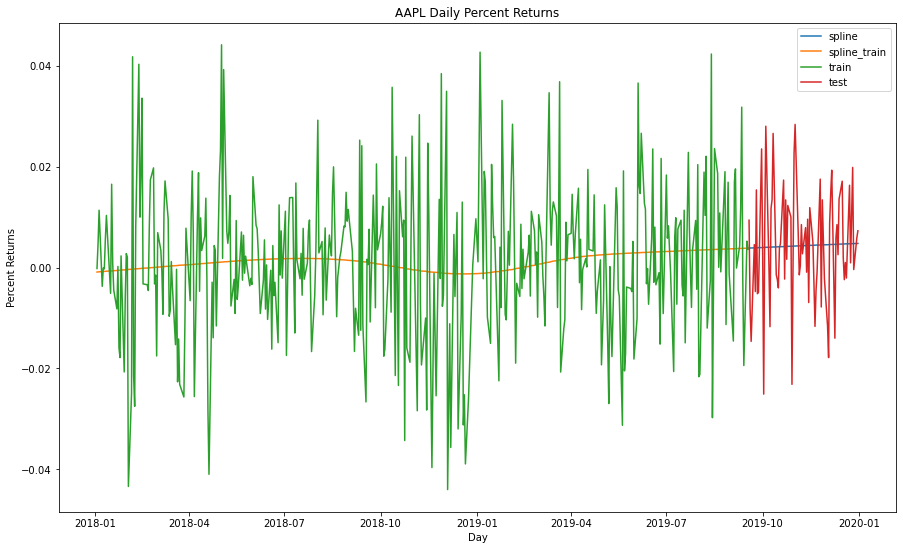

RMSE: 0.011276731410352717
MAE: 0.009002700186049385
MAPE: 234.47701110347862
MASE: 1.0012995016107678


In [965]:
in_sample_pred, pred = spline_reg(train, test, 6)

plt.plot(pred, label='spline')
plt.plot(in_sample_pred, label='spline_train')
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()
print(f'RMSE: {rmse(pred, test)}')
print(f'MAE: {mae(pred, test)}')
print(f'MAPE: {mape(pred, test)}')
print(f'MASE: {mase(pred, test, forecast_naive)}')

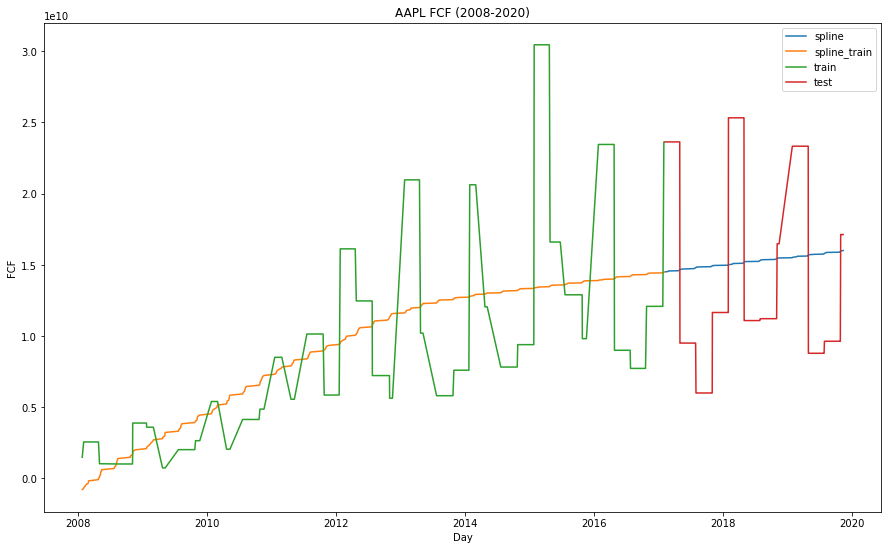

RMSE: 6939203542.514314
MAE: 6428427960.970908
MAPE: 52.23118600418117


In [970]:
in_sample_pred, pred = spline_reg(train_fcf, test_fcf, 3)

plt.plot(pred, label='spline')
plt.plot(in_sample_pred, label='spline_train')
plt.plot(train_fcf, label='train')
plt.plot(test_fcf, label='test')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()
print(f'RMSE: {rmse(pred, test_fcf)}')
print(f'MAE: {mae(pred, test_fcf)}')
print(f'MAPE: {mape(pred, test_fcf)}')

## Simple Exponential Smoothing
### The Simple Exponential Smoothing Forecast is a middle-ground between the naive and average methods. Here, we predict the price tomorrow as the weighted average sum of prices that came before where weights decrease exponentially as observations come from further in the past. The intuition here is that the price tomorrow is most influenced by the price today, then second most influenced by the price yesterday, and so on such that information has exponential decay.

## $\begin{equation}
  \hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots
\end{equation}$

## $\begin{align*}                                                                           
  \hat{y}_{T+1|T} & =  \sum_{j=0}^{T-1} \alpha(1-\alpha)^j y_{T-j} + (1-\alpha)^T \ell_{0}.
\end{align*}$

### This method is suitable for forecasting data with no clear trend or seasonal pattern.
### Hyperparameters: alpha (exponential rate of decay 0<=a<= 1)

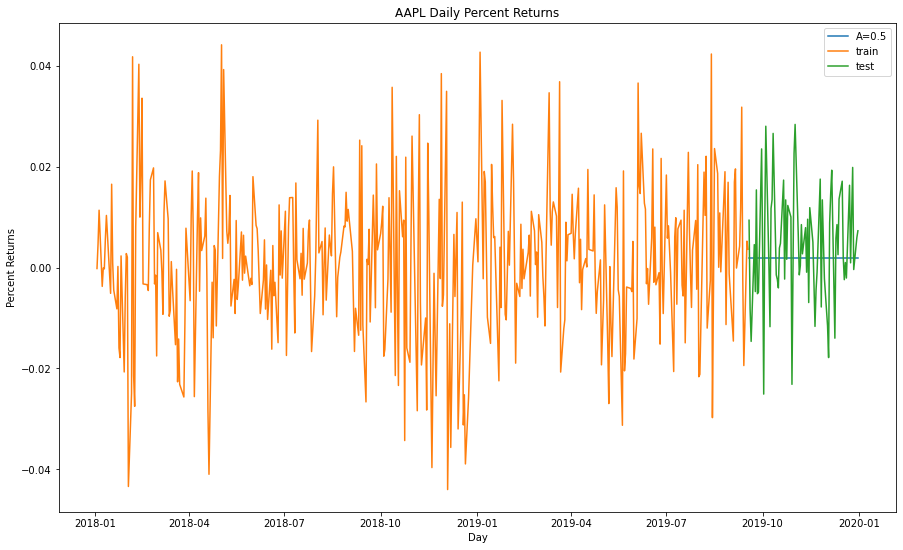

RMSE: 0.011487492859355327
MAE: 0.009041530831894412
MAPE: 145.10463400139503


In [989]:
reg1 = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level=0.5, optimized=True)
forecast1 = reg1.forecast(len(test))
forecast1 = pd.Series(forecast1, index = test.index)

plt.plot(forecast1, label="A=0.5")
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast1, test)}')
print(f'MAE: {mae(forecast1, test)}')
print(f'MAPE: {mape(forecast1, test)}')

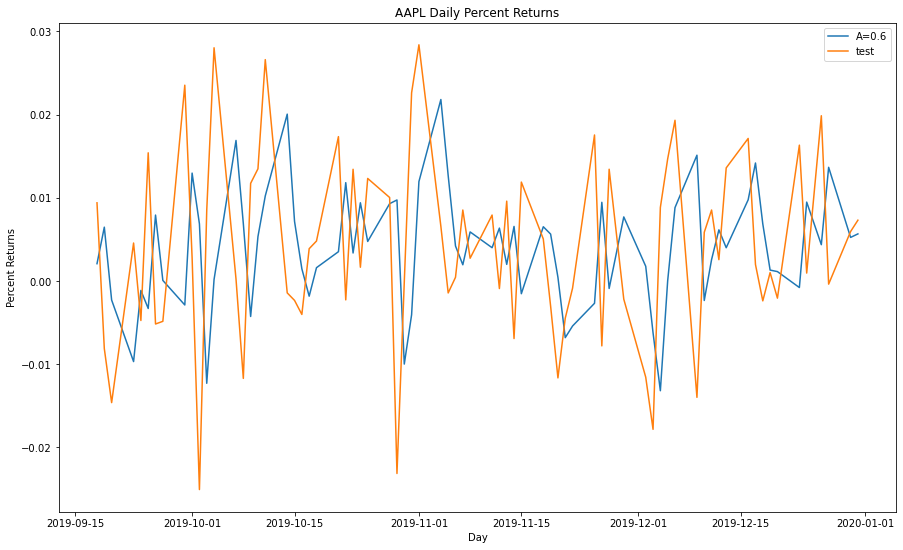

RMSE: 0.01401847144891928
MAE: 0.011846726910227348
MAPE: 477.94115697399036
MASE: 1.3176182151784972


In [990]:
rolling = train.to_list()
forecast = []
for day in test:
    reg1 = SimpleExpSmoothing(np.asarray(rolling)).fit(smoothing_level=0.6, optimized=True)
    pred = reg1.forecast(1)
    forecast.append(pred[0])
    rolling.append(day)

plt.plot(test.index, forecast, label="A=0.6")
#plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

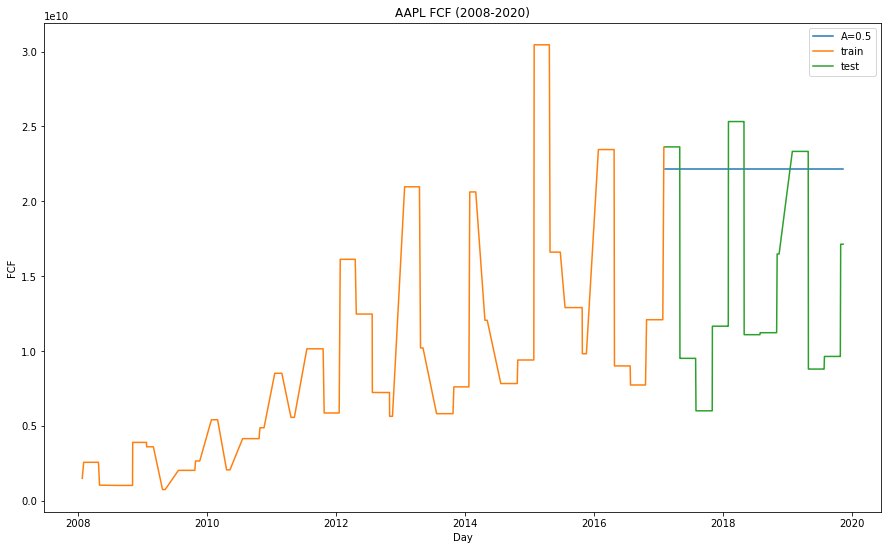

RMSE: 10026124225.656439
MAE: 8568557168.7980585
MAPE: 89.81014117788469


In [991]:
reg1 = SimpleExpSmoothing(np.asarray(train_fcf)).fit(smoothing_level=0.5, optimized=True)
forecast1 = reg1.forecast(len(test_fcf))
forecast1 = pd.Series(forecast1, index = test_fcf.index)

plt.plot(forecast1, label="A=0.5")
plt.plot(train_fcf, label="train")
plt.plot(test_fcf, label="test")
plt.legend()
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.show()
print(f'RMSE: {rmse(forecast1, test_fcf)}')
print(f'MAE: {mae(forecast1, test_fcf)}')
print(f'MAPE: {mape(forecast1, test_fcf)}')

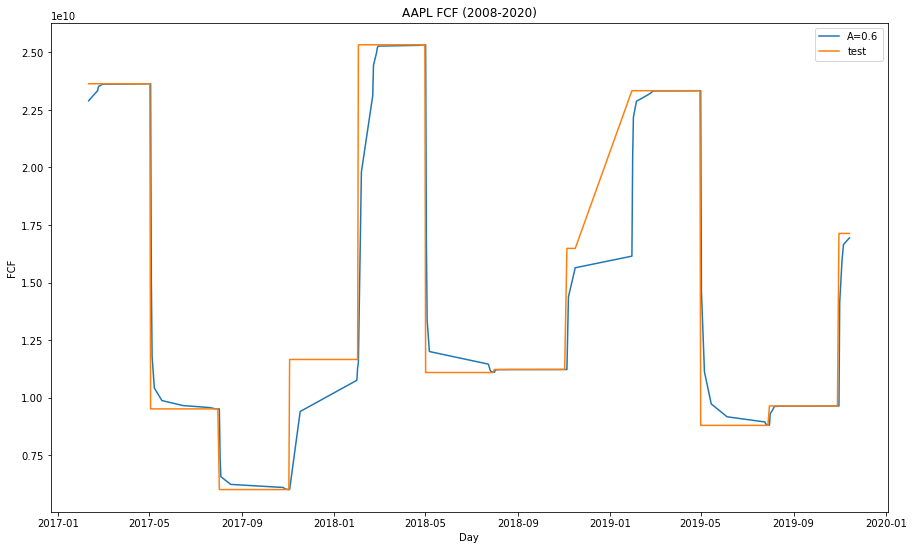

RMSE: 3408601299.115183
MAE: 1434830339.9691675
MAPE: 11.869187367762352


In [992]:
rolling = train_fcf.to_list()
forecast = []
for day in test_fcf:
    reg1 = SimpleExpSmoothing(np.asarray(rolling)).fit(smoothing_level=0.6, optimized=True)
    pred = reg1.forecast(1)
    forecast.append(pred[0])
    rolling.append(day)

plt.plot(test_fcf.index, forecast, label="A=0.6")
#plt.plot(train, label="train")
plt.plot(test_fcf, label="test")
plt.legend()
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

## Croston Method

### Croston's Method is used for forecasting time-series of intermittent demand. Essentially, we create two new time series from a single time series such that $q_{i}$ is the $ith$ non-zero value in the time series and $a_{i}$ is the time between $q_{i-1}$ and $q_{i}$. Two separate simple exponential smoothing forecasts are then fit on series $a$ and $q$. If $\hat{a}_{i+1|i}$ and $\hat{q}_{i+1|i}$ are one-step forecasts, then Croston's method can be expressed as:
### $\hat{q}_{i+1|i} = (1-\alpha)*\hat{q}_{i|i-1} + \alpha*q_{i}$

### $\hat{a}_{i+1|i} = (1-\alpha)*\hat{a}_{i|i-1} + \alpha*a_{i}$

### where $\alpha$ is a smoothing parameter between 0 and 1. We can then express the n-step prediction as:

### $\hat{y}_{T+n|T} = q_{j+1|j}/a_{j+1|j}$ where $j$ is the last observation


### Assumptions: An intermittent series has demand appear at random with many time periods showing no demand at all. Returns are centered around zero, where zero percent return is the most frequent observation in the time-series so we can model non-zero returns as a set of "intermittent" demand periods where demand inter-arrival time is short but frequent.
### Hyperparameters: Smoothing parameter alpha

In [993]:
def Croston(d, extra_periods=1,alpha=0.4):
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [999]:
def Croston_TSB(d,extra_periods=1,alpha=0.4,beta=0.1):
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [1000]:
df = Croston(test[:-1])
df = df.set_index(test.index)
df2 = Croston_TSB(test[:-1])
df2 = df2.set_index(test.index)

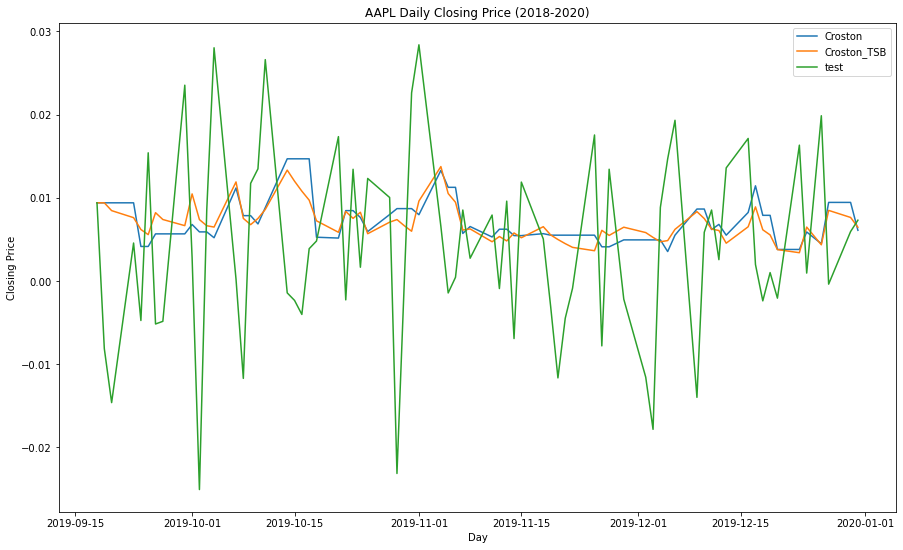

RMSE: 0.01243310253743701
MAE: 0.010331744800081125
MAPE: 426.54553098817763


In [1007]:
plt.plot(df['Forecast'], label='Croston')
plt.plot(df2['Forecast'], label='Croston_TSB')
plt.plot(test, label='test')
#plt.plot(train, label='train')
plt.title('AAPL Daily Closing Price (2018-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
pred = df['Forecast']
print(f'RMSE: {rmse(pred, test)}')
print(f'MAE: {mae(pred, test)}')
print(f'MAPE: {mape(pred, test)}')

### Holt Linear Trend
### Holt's Linear Trend is an extension of the Simple Exponential Smoothing forecast allowing for a forecast of both level and trend. Use this method over SES when trend is present.
### Hyperparameters: alpha (level smoothing parameter), beta (trend smoothing parameter)

### $\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}$

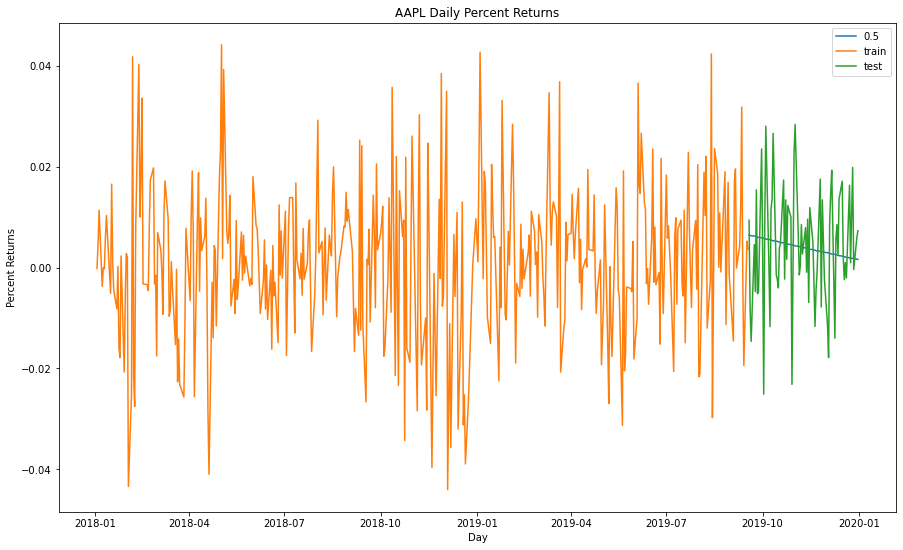

RMSE: 0.011445281111937211
MAE: 0.009109305440346632
MAPE: 225.05558243882504
MASE: 1.0131563651951325


In [1033]:
reg = Holt(np.asarray(train)).fit(smoothing_level = 0.1, smoothing_slope = 0.13)
forecast = reg.forecast(len(test))
forecast = pd.Series(forecast, index = test.index)

plt.plot(forecast, label="0.5")
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

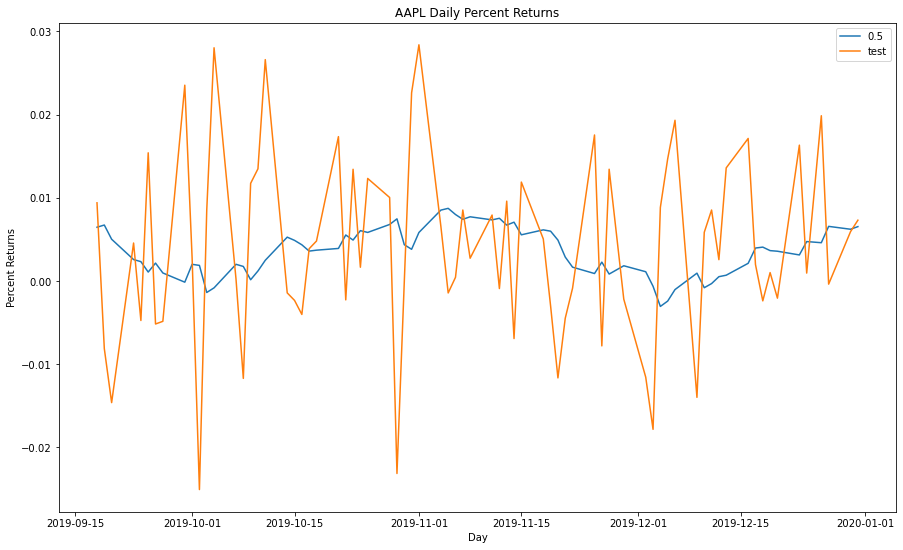

RMSE: 0.012095460891245895
MAE: 0.00966721482640902
MAPE: 250.18860414267786
MASE: 1.075208236152015


In [1036]:
rolling = train.to_list()
forecast = []
for day in test:
    reg = Holt(np.asarray(rolling)).fit(smoothing_level = 0.1, smoothing_slope = 0.13)
    pred = reg.forecast(1)[0]
    forecast.append(pred)
    rolling.append(day)

plt.plot(test.index, forecast, label="0.5")
#plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')
print(f'MASE: {mase(forecast, test, forecast_naive)}')

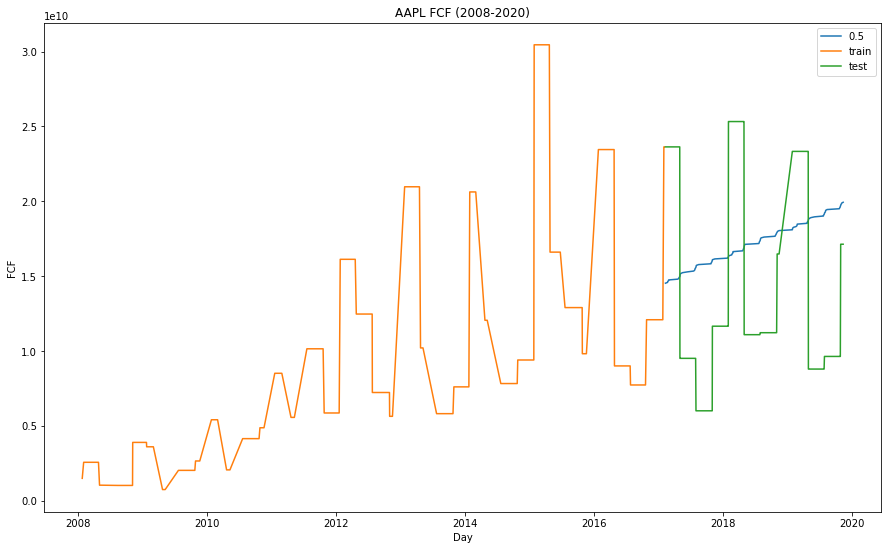

RMSE: 7555845170.331544
MAE: 7165009436.678538
MAPE: 62.93273180799119


In [1048]:
reg = Holt(np.asarray(train_fcf)).fit(smoothing_level = 0.12, smoothing_slope = 0.03)
forecast = reg.forecast(len(test_fcf))
forecast = pd.Series(forecast, index = test_fcf.index)

plt.plot(forecast, label="0.5")
plt.plot(train_fcf, label='train')
plt.plot(test_fcf, label='test')
plt.legend()
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

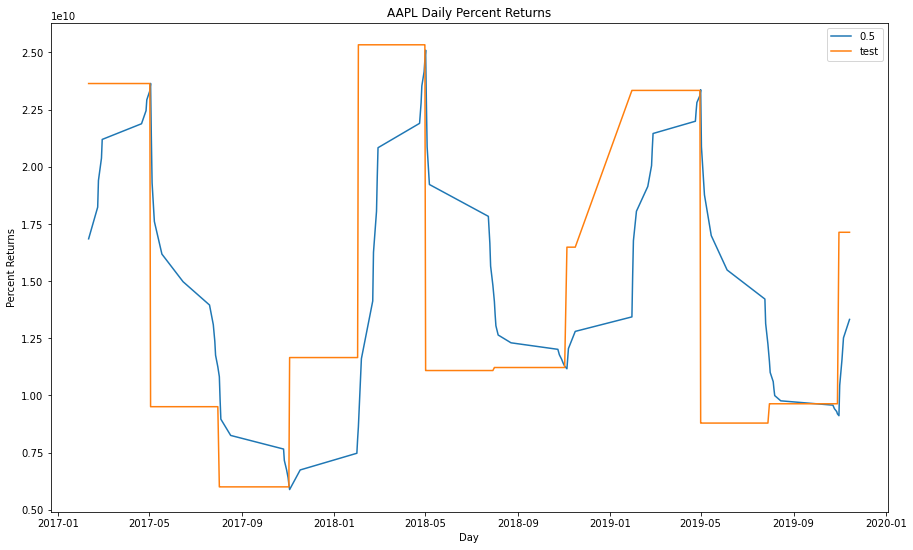

RMSE: 5857348355.774377
MAE: 4404072064.236844
MAPE: 35.08593936427486


In [1053]:
rolling = train_fcf.to_list()
forecast = []
for day in test_fcf:
    reg = Holt(np.asarray(rolling)).fit(smoothing_level = 0.18, smoothing_slope = 0.03)
    pred = reg.forecast(1)[0]
    forecast.append(pred)
    rolling.append(day)

plt.plot(test_fcf.index, forecast, label="0.5")
#plt.plot(train, label='train')
plt.plot(test_fcf, label='test')
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

### Holt Winter Exponential Smoothing
### This is an extension of Holt Linear Trend for the inclusion of seasonality. We now have an additional smoothing parameter (gamma) for the seasonal term. We use m to denote the length of the seasonal period.
### There are two versions of Holt Winter's Seasonal Model:
    1) Additive: seasonal variations are roughly constant through the series
    2) Multiplicative: seasonal variations change in proportion to level

### Additive

## $\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}$

### Multiplicative

## $\begin{align*}
  \hat{y}_{t+h|t} &= (\ell_{t} + hb_{t})s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}                \\
  s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}
\end{align*}$

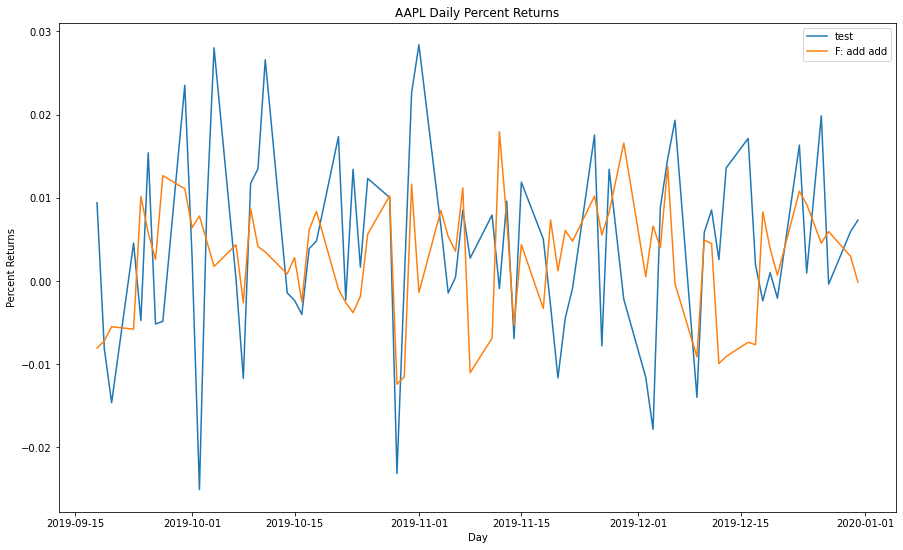

RMSE: 0.012259775916050897
MAE: 0.009699255258223
MAPE: 372.65709364019546


In [1103]:
hyper = [60]
trend = ['add', 'mul']
#plt.plot(train, label='train')
plt.plot(test, label='test')

#Holt Linear Trend
for i in hyper:
    for j in trend:
        for k in trend:
            try:
                reg2 = ExponentialSmoothing(np.asarray(train), seasonal_periods=i ,trend=j, seasonal=k).fit()
            except Exception as e:
                #print(e)
                continue
            forecast2 = reg2.forecast(len(test))
            forecast2 = pd.Series(forecast2, index = test.index)
            plt.plot(forecast2, label="F: "+str(j)+" "+str(k))
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast2, test)}')
print(f'MAE: {mae(forecast2, test)}')
print(f'MAPE: {mape(forecast2, test)}')

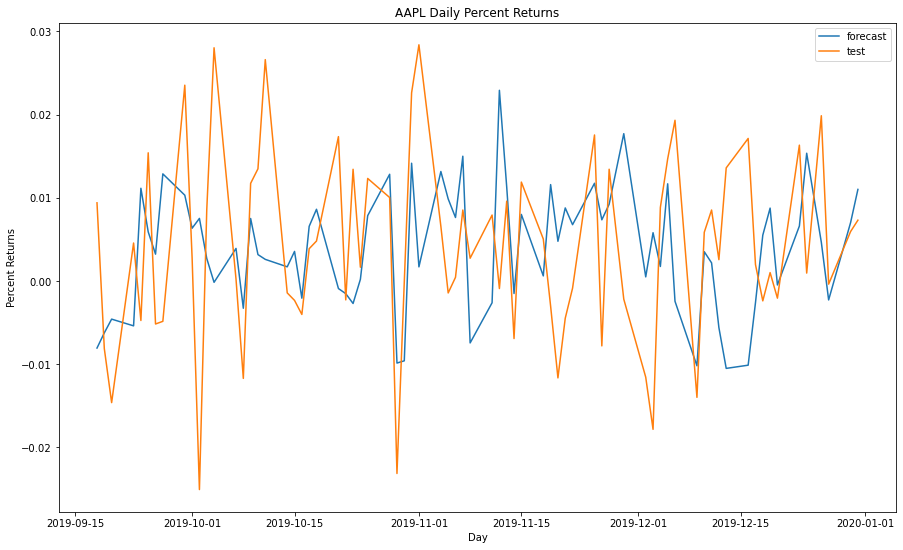

RMSE: 0.01267877660807003
MAE: 0.010136189827134635
MAPE: 370.8126135859984


In [1104]:
rolling = train.to_list()
forecast = []

for day in test:
    reg = ExponentialSmoothing(np.asarray(rolling), seasonal_periods=60 ,trend='add', seasonal='add').fit()
    pred = reg.forecast(1)[0]
    forecast.append(pred)
    rolling.append(day)

plt.plot(test.index, forecast, label="forecast")
plt.plot(test, label='test')
plt.legend()
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.show()
print(f'RMSE: {rmse(forecast, test)}')
print(f'MAE: {mae(forecast, test)}')
print(f'MAPE: {mape(forecast, test)}')

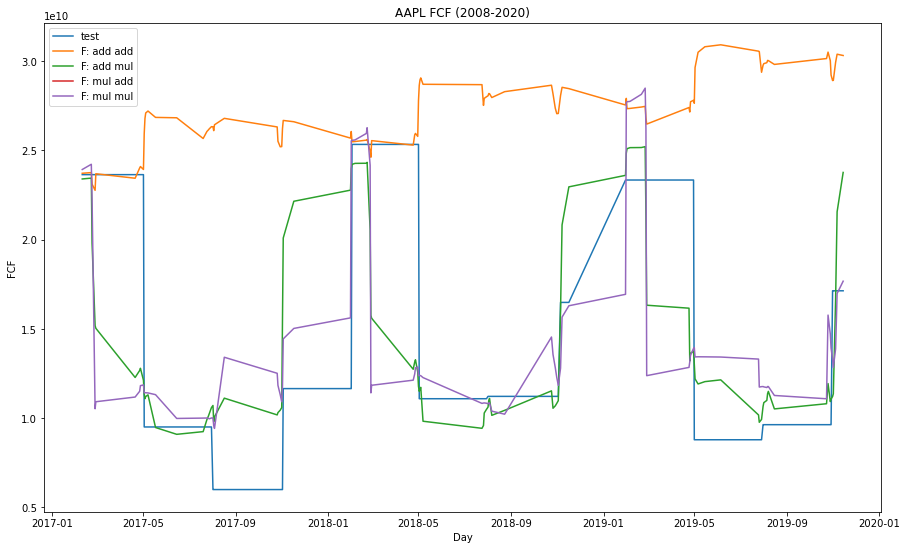

RMSE: nan
MAE: 14464207065.582058
MAPE: 542953277351610.75


In [1105]:
hyper = [35]
trend = ['add', 'mul']
#plt.plot(train, label='train')
plt.plot(test_fcf, label='test')
#plt.plot(train_fcf)

#Holt Linear Trend
for i in hyper:
    for j in trend:
        for k in trend:
            try:
                reg2 = ExponentialSmoothing(np.asarray(train_fcf), seasonal_periods=i ,trend=j, seasonal=k).fit()
            except Exception as e:
                #print(e)
                continue
            forecast2 = reg2.forecast(len(test_fcf))
            forecast2 = pd.Series(forecast2, index = test_fcf.index)
            plt.plot(forecast2, label="F: "+str(j)+" "+str(k))
plt.legend()
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.show()
print(f'RMSE: {rmse(forecast2, test)}')
print(f'MAE: {mae(forecast2, test)}')
print(f'MAPE: {mape(forecast2, test)}')

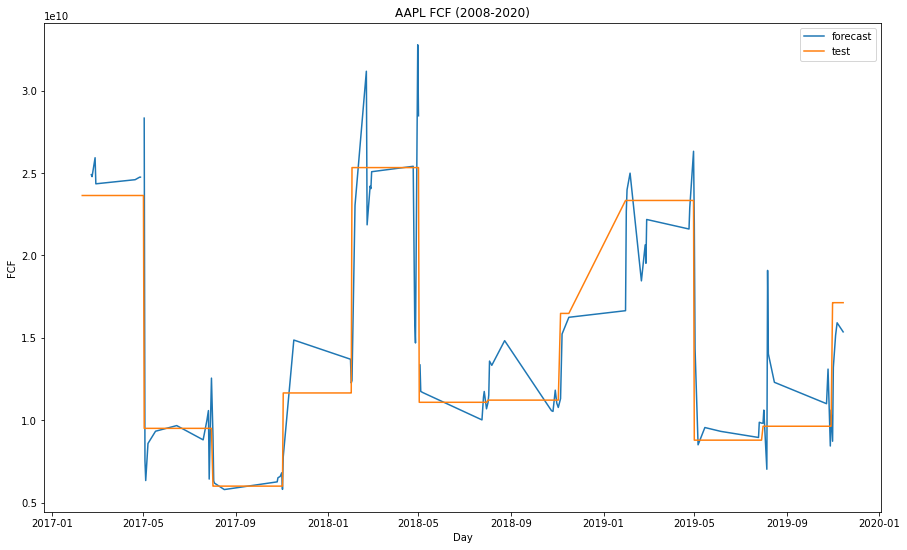

RMSE: nan
MAE: 2390094288.205741
MAPE: 17.9125567198811


In [1106]:
rolling = train_fcf.to_list()
forecast = []

for day in test_fcf:
    reg = ExponentialSmoothing(np.asarray(rolling), seasonal_periods=60 ,trend='mul', seasonal='mul').fit()
    pred = reg.forecast(1)[0]
    forecast.append(pred)
    rolling.append(day)

plt.plot(test_fcf.index, forecast, label="forecast")
plt.plot(test_fcf, label='test')
plt.legend()
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.show()
print(f'RMSE: {rmse(forecast, test_fcf)}')
print(f'MAE: {mae(forecast, test_fcf)}')
print(f'MAPE: {mape(forecast, test_fcf)}')

# ARIMA
### For overview of ARIMA read my previous work: [Intro to Time Series Forecasting](https://www.smithinvestmentfund.com/blog/research-introduction-to-statistical-time-series-forecasting-and-stock-market-clustering)

In [1114]:
def predict_auto_arima(data, target, columns, split, days_ahead, verbose = True):
    sbn.set(font_scale=1.2)
    predicted_returns = {}
    datasets = []
    count = 1
    for col in columns:
        print(f'Processing ticker {count}')
        print(col)
        print('\n')
        X = data[target][col]
        X = X.dropna()
        differenced = X.diff()
        datasets.append(differenced)
        if verbose:
            
            #Plot the Time Series for close data
            plt.figure(figsize=(10,10))
            plt.plot(X)
            plt.title(col)
            plt.ylabel(str(target))
            plt.xlabel('Date')
            plt.show()
        
            #Check if the data is Stationary with Augmented Dicky-Fuller Test
            print("Is the Data Stationary? (Augmented Dicky-Fuller Test)")
            adf_test = ADFTest(alpha = 0.05)
            dicky_res = adf_test.should_diff(X)
            print('p-value: '+str(dicky_res[0]))
            print('The Time Series is Stationary? '+str(False if dicky_res[1] else True))
            print("\n")
    
        train, test = X[0:int(len(X)*split)], X[int(len(X)*split):] #Create train/test split
        test_set_range = test.index 
        train_set_range = train.index
        if verbose:
            #Plot the time series and denote the training period and the testing period
            plt.figure(figsize=(10,10))
            plt.plot(train_set_range, train, label = 'train')
            plt.plot(test_set_range, test, label = 'test')
            plt.title(col)
            plt.xlabel('Date')
            plt.ylabel(str(target))
            plt.legend()
            plt.show()
    
            #Plot the ACF graph
            plt.figure(figsize=(10,10))
            sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40)
            #plt.show()
            
            #Plot the PACF graph
            plt.figure(figsize=(10,10))
            sm.graphics.tsa.plot_pacf(X.values.squeeze(), lags=40)
            #plt.show()
    
        #Automatically fit an ARIMA model to the time series
        n_diffs = 2
        trace = False
        if verbose:
            trace = True
        else:
            trace = False
        auto = pm.auto_arima(train, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=10, max_q = 10, max_d = 10,
                     max_order=None, random_state = 9, n_fits = 50, trace=trace)
        if verbose:
            print(auto.summary())
    
        #Create a dataframe of predicted close price for the period 
        df = pd.DataFrame()
        df["date"] = pd.date_range(test.index[0], periods=days_ahead, freq="D")
        df = df.set_index(df["date"])
        prediction = pd.DataFrame(auto.predict(n_periods = days_ahead), index = df.index)
        prediction.columns = ['predicted_close']
        
        if verbose:
            #plot the n-day prediction against the testing period
            plt.figure(figsize=(10,10))
            plt.plot(train, label = "train")
            plt.plot(test, label="test")
            plt.plot(prediction, label = "predicted")
            plt.title(col)
            plt.xlabel('Date')
            plt.ylabel('Closing Price')
            plt.legend()
            plt.show()
    
        pred_price = prediction.iloc[-1][0]
        print(prediction)

        bought_price = train.iloc[-1]
        print(bought_price)
        
        print("Predicted Return:")
        pred_ret = (pred_price-bought_price)/bought_price        
        
        predicted_returns[col] = prediction
        print(pred_ret)
        print("\n")
        
        print("Actual Return:")
        try:
            print((test.iloc[days_ahead] - bought_price)/bought_price)
        except:
            print("Date for Prediction not in Testing Period")
        print("\n")
        
        #Calculate a Rolling Daily Prediction using ARIMA and calculate Mean Squared Error
        train_data, test_data = X[0:int(len(X)*split)], X[int(len(X)*split):]
        training_data = train_data.values
        test_data = test_data.values
        history = [x for x in training_data]
        model_predictions = []
        N_test_observations = len(test_data)
        for time_point in range(N_test_observations):
            model = ARIMA(history, order=(4,2,0))
            model_fit = model.fit(disp=2)
            output = model_fit.forecast()
            yhat = output[0]
            model_predictions.append(yhat)
            true_test_value = test_data[time_point]
            history.append(true_test_value)
        MSE_error = mean_squared_error(test_data, model_predictions)
        if verbose:
            print('Testing Mean Squared Error is {}'.format(MSE_error))
        
        test_set_range = X[int(len(X)*split):].index
        if verbose:
            #Plot the rolling predictions during the testing period
            plt.figure(figsize=(10,10))
            plt.plot(test_set_range, model_predictions, color='blue',  linestyle='dashed',label='Predicted Price')
            plt.plot(test_set_range, test_data, color='red', label='Actual Price')
            plt.title(str(col) + ' Closing Price Prediction')
            plt.xlabel('Date')
            plt.ylabel('Prices')
            plt.legend()
            plt.show()
    
        count += 1

    return predicted_returns, datasets

# TBATS
## Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components (TBATS) is an automated forecasting model that uses a combination of Fourier terms with an exponential smoothing state space model and a Box-Cox transformation where seasonality is allowed to change slowly over time.

### Disadvantage: Extremely computationally costly

![TBATs](media/TBATs.png)

In [1119]:
from tbats import TBATS, BATS

In [1124]:
estimator = TBATS(seasonal_periods=[14.5, 30.25], use_arma_errors=None, use_trend=None, use_damped_trend=None, show_warnings=True)
model = estimator.fit(train)

# Forecast 365 days ahead
y_forecast = model.forecast(steps=len(test))

In [1125]:
params = model.params
components = model.params.components

In [1126]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): -0.009607
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [0.0005647]

AIC -988.104069


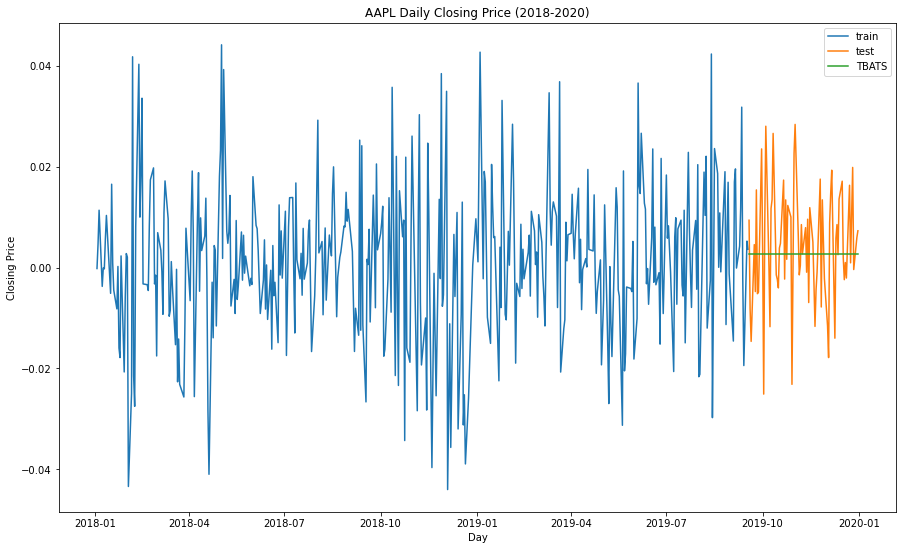

In [1127]:
forecast = pd.Series(y_forecast, index = test.index)
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(forecast, label='TBATS')
plt.title('AAPL Daily Closing Price (2018-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [1128]:
train_dummy = list(train)
preds = []
for day in test[:15]:
    estimator = TBATS()
    model = estimator.fit(train_dummy)
    
    preds.append(model.forecast(steps=1)[0])
    train_dummy.append(day)
print(preds)

[0.002748321617058816, 0.002813730557422486, 0.0027068930717572973, 0.0025428146823091267, 0.0025617258283404066, 0.0024935295408952964, 0.002615192209305747, 0.0025419492433758056, 0.00247331509114432, 0.00267318620128965, 0.0026739103091700978, 0.002417104499882158, 0.0024726374985703605, 0.00271535046977616, 0.002691419293904602]


In [85]:
pred2 = []
for x in preds:
    pred2.append(x[0])
preds = pred2

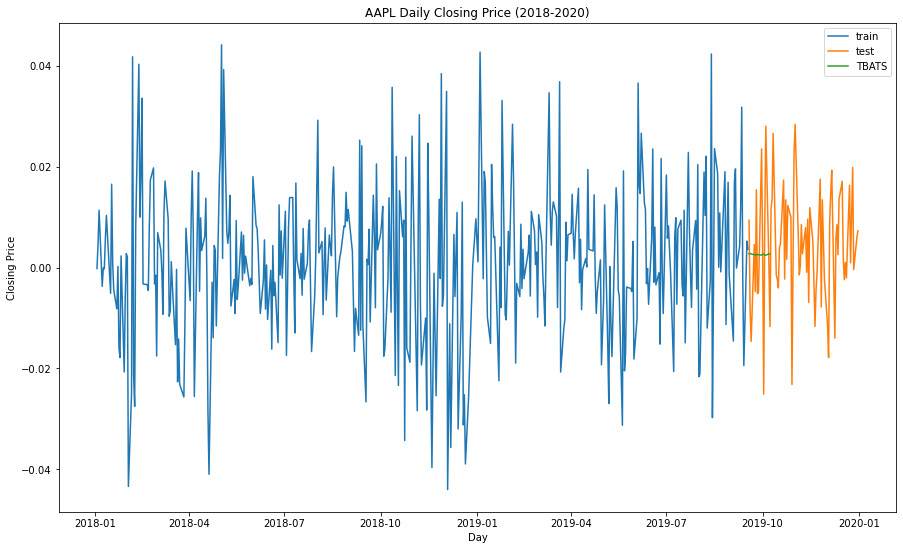

In [1129]:
forecast = pd.Series(preds, index = test[0:15].index)
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(forecast, label='TBATS')
plt.title('AAPL Daily Closing Price (2018-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## The challenge with ARIMA-based models like ARIMA and TBATs is that returns are modelled as white noise models (in essence, ARIMA cannot identify a model that is significantly better than the random one)

# Facebook [Prophet](https://facebook.github.io/prophet/)

## Facebook developed an Open Source forecasting model described as follows: "Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."

2021-04-27 17:46:42.529 (INFO): Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-04-27 17:46:42.531 (INFO): Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


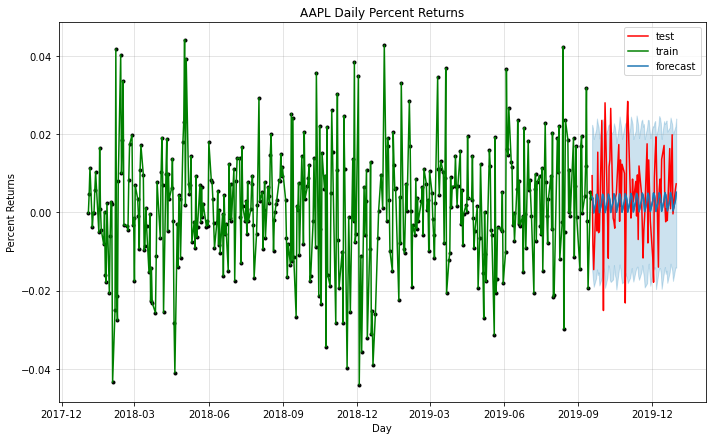

RMSE: 0.011917464132787511
MAE: 0.009346719850606259
MAPE: 202.10685641627254


In [1146]:
from pandas import to_datetime
import fbprophet
from fbprophet import Prophet

df_train = pd.DataFrame({ 'ds': train.index, 'y': train } )
df_train['ds'] = to_datetime(df_train['ds'])
df_train.head()

df_test = pd.DataFrame({'ds':test.index})
df_test['ds'] = to_datetime(df_test['ds'])

model = Prophet()
model.fit(df_train)

forecast = model.predict(df_test)
model.plot(forecast)
plt.plot(test, "red", label = 'test')
plt.plot(train, "green", label='train')
plt.plot(test.index, forecast['yhat'], label='forecast')
plt.title('AAPL Daily Percent Returns')
plt.xlabel('Day')
plt.ylabel('Percent Returns')
plt.legend()
plt.show()

pred = forecast['yhat'].to_list()
print(f'RMSE: {rmse(pred, test)}')
print(f'MAE: {mae(pred, test)}')
print(f'MAPE: {mape(pred, test)}')

2021-04-27 17:47:59.347 (INFO): Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


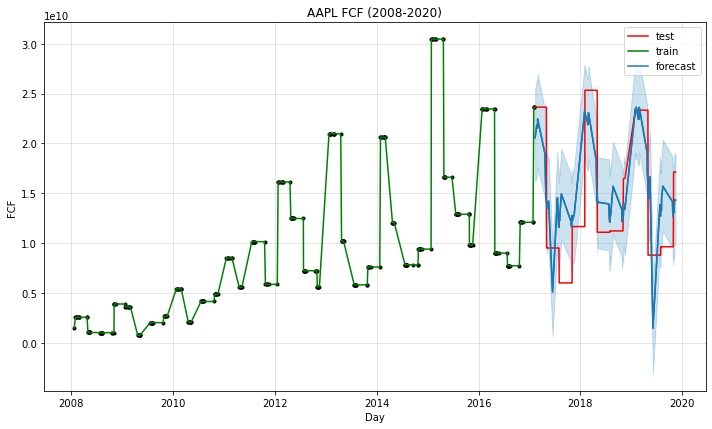

RMSE: 4908359551.647905
MAE: 4110845693.43984
MAPE: 36.31971733551553


In [1147]:
df_train = pd.DataFrame({ 'ds': train_fcf.index, 'y': train_fcf } )
df_train['ds'] = to_datetime(df_train['ds'])

df_test = pd.DataFrame({'ds':test_fcf.index})
df_test['ds'] = to_datetime(df_test['ds'])

model = Prophet()
model.fit(df_train)

forecast = model.predict(df_test)
model.plot(forecast)
plt.plot(test_fcf, "red", label = 'test')
plt.plot(train_fcf, "green", label='train')
plt.plot(test_fcf.index, forecast['yhat'], label='forecast')
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('Day')
plt.ylabel('FCF')
plt.legend()
plt.show()

pred = forecast['yhat'].to_list()
print(f'RMSE: {rmse(pred, test_fcf)}')
print(f'MAE: {mae(pred, test_fcf)}')
print(f'MAPE: {mape(pred, test_fcf)}')

# [Bayesian Dynamic Linear Model](https://pydlm.github.io/pydlm_user_guide.html)
### The Bayesian Dynamic Linear Model implements a modified Kalman filter technique from Harrison and West (1999). A Kalman Filter is an optimal estimation algorithm that is used to estimate the "state" of a system by combining signals that may be subject to random noise. DLM filters noise out of the time series input and uses linear trend and seasonality to build a prediction

In [1148]:
from pydlm import dlm, trend, seasonality

In [1160]:
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=10)
# Build a simple dlm
simple_dlm = dlm(train) + linear_trend + seasonal52
simple_dlm2 = dlm(equity_data['close']['AAPL']) + linear_trend + seasonal52
simple_dlm3 = dlm(train_fcf) + linear_trend + seasonal52

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...


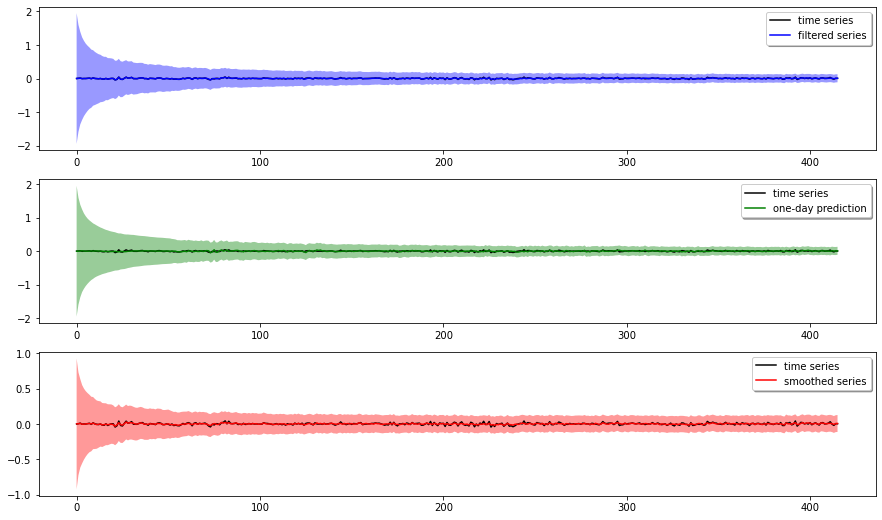

In [1169]:
simple_dlm.fit()
simple_dlm2.fit()
simple_dlm3.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

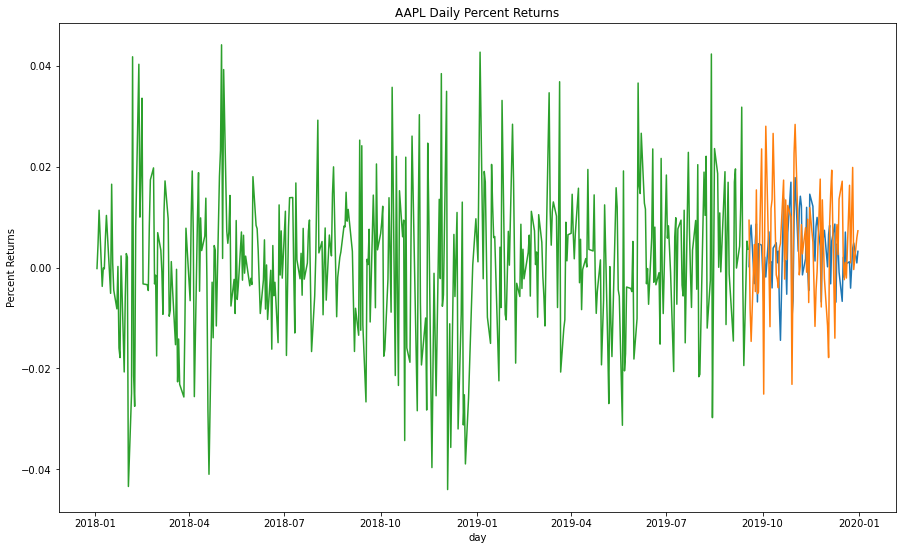

RMSE: 0.011880507587445964
MAE: 0.009922276002442623
MAPE: 352.41848989971453


In [1186]:
pred = simple_dlm.predictN(N=len(test))[0]
plt.plot(test.index, pred)
plt.plot(test)
plt.plot(train)
plt.title('AAPL Daily Percent Returns')
plt.xlabel('day')
plt.ylabel('Percent Returns')
plt.show()

print(f'RMSE: {rmse(pred, test)}')
print(f'MAE: {mae(pred, test)}')
print(f'MAPE: {mape(pred, test)}')

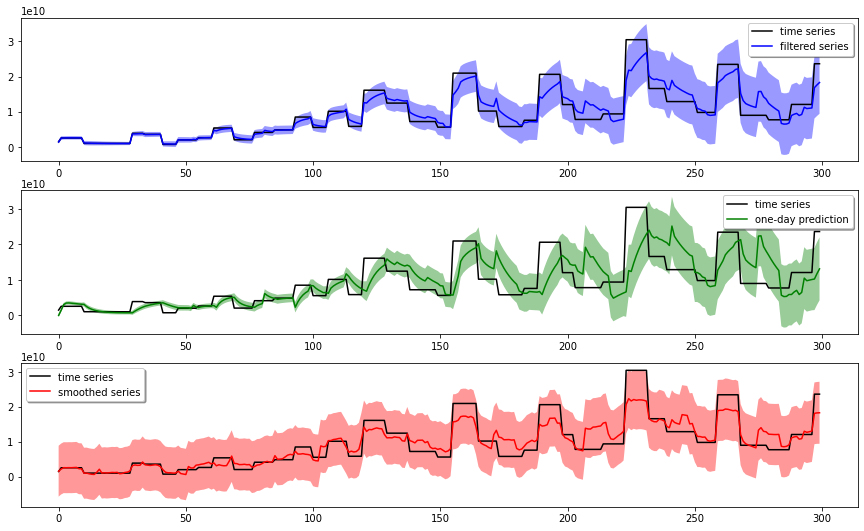

In [1163]:
simple_dlm3.turnOff('data points')
simple_dlm3.plot()

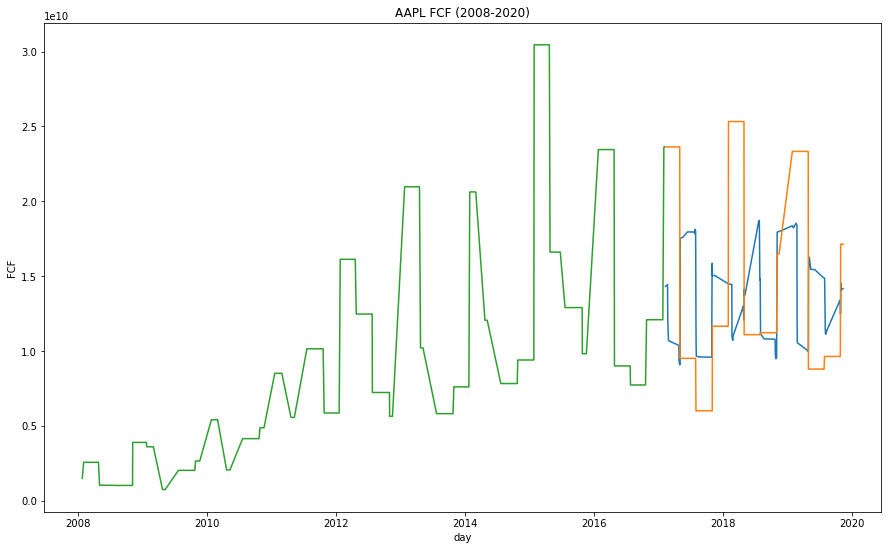

RMSE: 7854423883.007865
MAE: 6491765846.207184
MAPE: 45.96489866145528


In [1189]:
pred = simple_dlm3.predictN(N=len(test_fcf))[0]
plt.plot(test_fcf.index, pred)
plt.plot(test_fcf)
plt.plot(train_fcf)
plt.title('AAPL FCF (2008-2020)')
plt.xlabel('day')
plt.ylabel('FCF')
plt.show()

print(f'RMSE: {rmse(pred, test_fcf)}')
print(f'MAE: {mae(pred, test_fcf)}')
print(f'MAPE: {mape(pred, test_fcf)}')

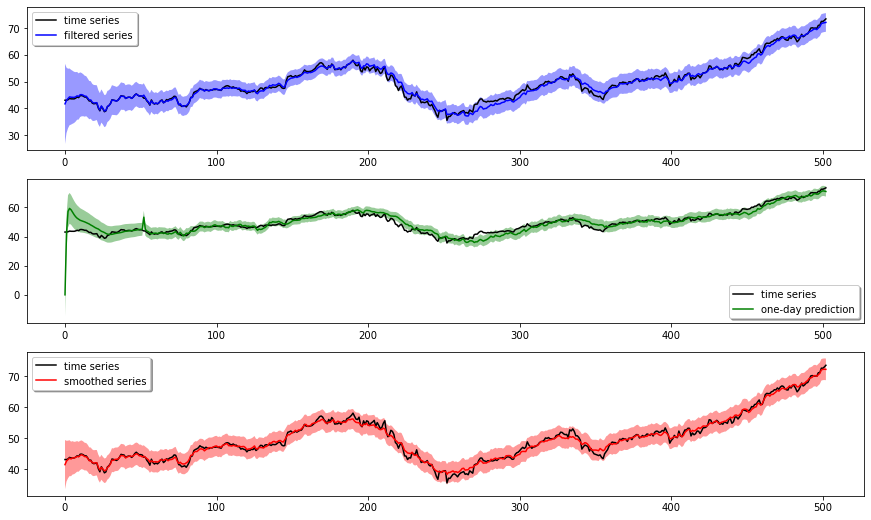

In [1164]:
simple_dlm2.turnOff('data points')
simple_dlm2.plot()

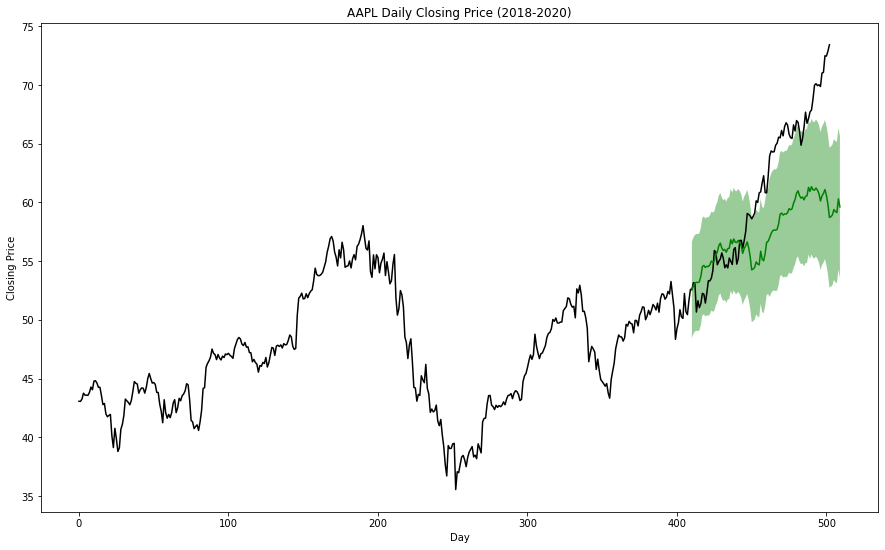

In [1190]:
plt.title('AAPL Daily Closing Price (2018-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
simple_dlm2.plotPredictN(date=410, N=100)
plt.show()

# VARMA

## A major limitation of the above models is that a) for the most part they only consider a univariate relationship and b) models that do use multivariate relationships impose a unidirectional relationship such that the forcasted variable is dependent on the predictor variables but not vice versa. In many cases, such as in the stock market, the reverse case also holds. For instance, Amazon and Alibaba are both online retailers competing in the same industry. It then stems that day-to-day operations of these two companies will affect each others stock prices.

## We explore here a simple example of mutually forecasting Amazon and Alibaba stock price using the VARMA model. The VARMA model is a vector parameterized version of the ARIMA model that allows for multiple time series inputs and not just one predictor.

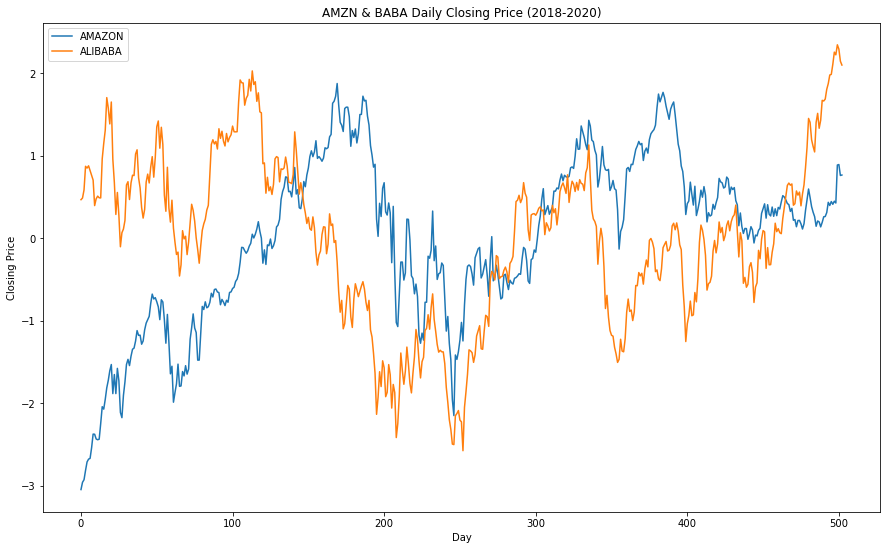

In [1232]:
df_temp = equity_data['close'][['AMZN', 'BABA']]
#df_temp['z_AMZN'] = stats.zscore(df_temp['AMZN'])
#df_temp['z_BABA'] = stats.zscore(df_temp['BABA'])
plt.plot(stats.zscore(df_temp['AMZN']), label = 'AMAZON')
plt.plot(stats.zscore(df_temp['BABA']), label = 'ALIBABA')
plt.title('AMZN & BABA Daily Closing Price (2018-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. A time series X is said to Granger-cause Y if it can be shown through a series of t-tests and F-tests on lagged values of X that those X values provide statistically significant information about future values of Y.

In [1226]:
from statsmodels.tsa.stattools import grangercausalitytests

In [1235]:
def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):
    maxlag=12

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(df_temp, variables = df_temp.columns)  

AMZN_x  BABA_x
AMZN_y  1.0000  0.0717
BABA_y  0.0046  1.0000

## using a p-value cut-off of 0.1, we can see that Amazon and Alibaba are useful in forcasting one another

In [1243]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [1244]:
df_temp['z_AMZN'] = stats.zscore(df_temp['AMZN'])
df_temp['z_BABA'] = stats.zscore(df_temp['BABA'])
df_temp2 = df_temp[['z_AMZN', 'z_BABA']].iloc[0:430]

In [1245]:
df_temp.shape

(503, 4)

In [1246]:
model = VAR(df_temp2)
model_fit = model.fit()
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Apr, 2021
Time:                     19:26:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.88145
Nobs:                     429.000    HQIC:                  -6.91582
Log likelihood:           276.806    FPE:                0.000969965
AIC:                     -6.93825    Det(Omega_mle):     0.000956540
--------------------------------------------------------------------
Results for equation z_AMZN
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.007619         0.009266            0.822           0.411
L1.z_AMZN         0.975683         0.008644          112.871           0.000
L1.z_BABA         0.004040         0.009401            0.430           0.66

In [1249]:
pred = model_fit.forecast(model_fit.y, steps=df_temp.shape[0]-430)

y_preds = pred[:,1]
x_preds = pred[:,0]

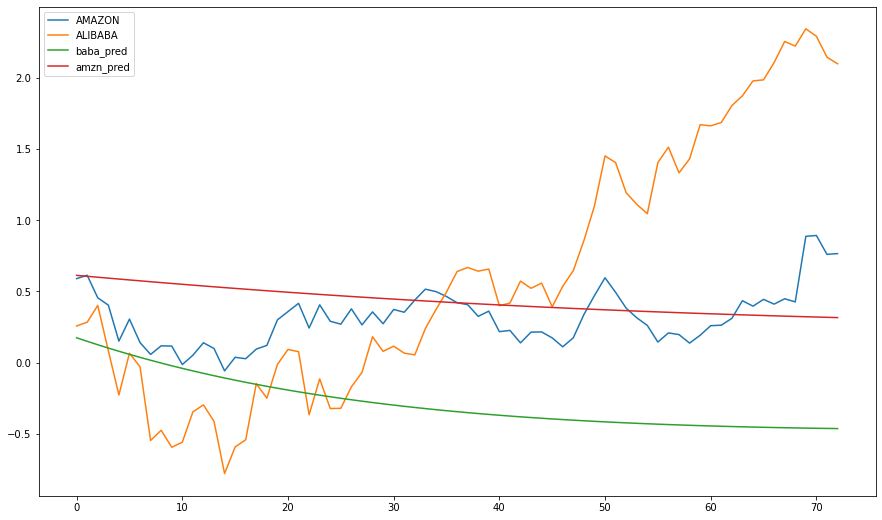

In [1250]:
plt.plot(list(df_temp['z_AMZN'].iloc[430:]), label = 'AMAZON')
plt.plot(list(df_temp['z_BABA'].iloc[430:]), label = 'ALIBABA')
plt.plot(y_preds, label = 'baba_pred')
plt.plot(x_preds, label = 'amzn_pred')
plt.legend()
plt.show()

# Conclusion

### In conclusion, we have developed a framework for statistical time-series forecasting and analysis by going through a tour of advanced forecasting techniques. This allows researchers to analyze market forces, interactions, and anomalies. We are also able to compare signals and develop forcasted signals that may be used as intermediaries for various valuation models such as the Discounted Cash Flow Model.

### Forecasting stock prices is just as difficult as prophesized and often even more complicated models have a difficult time performing better than the naive model. Although these preliminary results seem to show that some minor inefficiencies exist we cannot conclude currently that these results are significant. Further work is needed to conclude whether or not these forecasted signals can be used to find alpha. In order to refute or support the strong-form Efficient Market Hypothesis, an extension of the work above will be conducted on a universe of stocks.